In [26]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

from generators import BlockDiagonalMatrixGenerator, BlockMatrixGenerator
from datasets import MovieLensGenreCastUserData, RatioSplit, CrossValidation
from models import BinaryMFThreshold, BinaryMFThresholdExCustomFactors

import os
import time
import logging
from scipy.sparse import csr_matrix
from cmfrec import CMF
import numpy as np, pandas as pd, pickle

from utils import binarize, show_matrix, matmul, fill_nan

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
k = 50
lambda_ = 10
maxiter = 800

# Loading ml-1m with negative sampling

In [28]:
root = os.path.abspath("../../cmfrec/example")

ratings = pickle.load(open(os.path.join(root, "ratings.p"), "rb"))
item_sideinfo_pca = pickle.load(open(os.path.join(root, "item_sideinfo_pca.p"), "rb"))
user_side_info = pickle.load(open(os.path.join(root, "user_side_info.p"), "rb"))
movie_id_to_title = pickle.load(open(os.path.join(root, "movie_id_to_title.p"), "rb"))
print(ratings.shape, user_side_info.shape, item_sideinfo_pca.shape)

(1000209, 3) (6040, 39) (3102, 51)


In [34]:
data = MovieLensGenreCastUserData(size='100k')
data.load()
data.Xs

[<943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 <943x81 sparse matrix of type '<class 'numpy.float64'>'
 	with 3499 stored elements in Compressed Sparse Row format>,
 <26x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 4031 stored elements in Compressed Sparse Row format>,
 <4708x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 8306 stored elements in Compressed Sparse Row format>]

In [35]:
# _ = data.sample(0, n_samples=10)
# data.factor_info

In [36]:
X, Y, Z, _ = data.Xs

In [37]:
X_split = RatioSplit(X, test_size=20000)
X_split

[I] RatioSplit, sampling positives
[I]   seed         : 1705915390
[I]   train_size   : 80000
[I]   val_size     : 0
[I]   test_size    : 20000
[I]   seed         : 1705915390


In [38]:
X_split.negative_sample(train_size=X_split.pos_train_size, test_size=X_split.pos_test_size, type='popularity')
X_split

[I] RatioSplit, sampling negatives
[I]   all_negatives: 1486126
[I]   n_negatives  : 100000
[I]   train_size   : 80000
[I]   val_size     : 0
[I]   test_size    : 20000
[I]   seed         : 1705915390


c:\Users\nieht\Anaconda3\envs\cornac\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [39]:
X_train, X_test = X_split.X_train, X_split.X_test

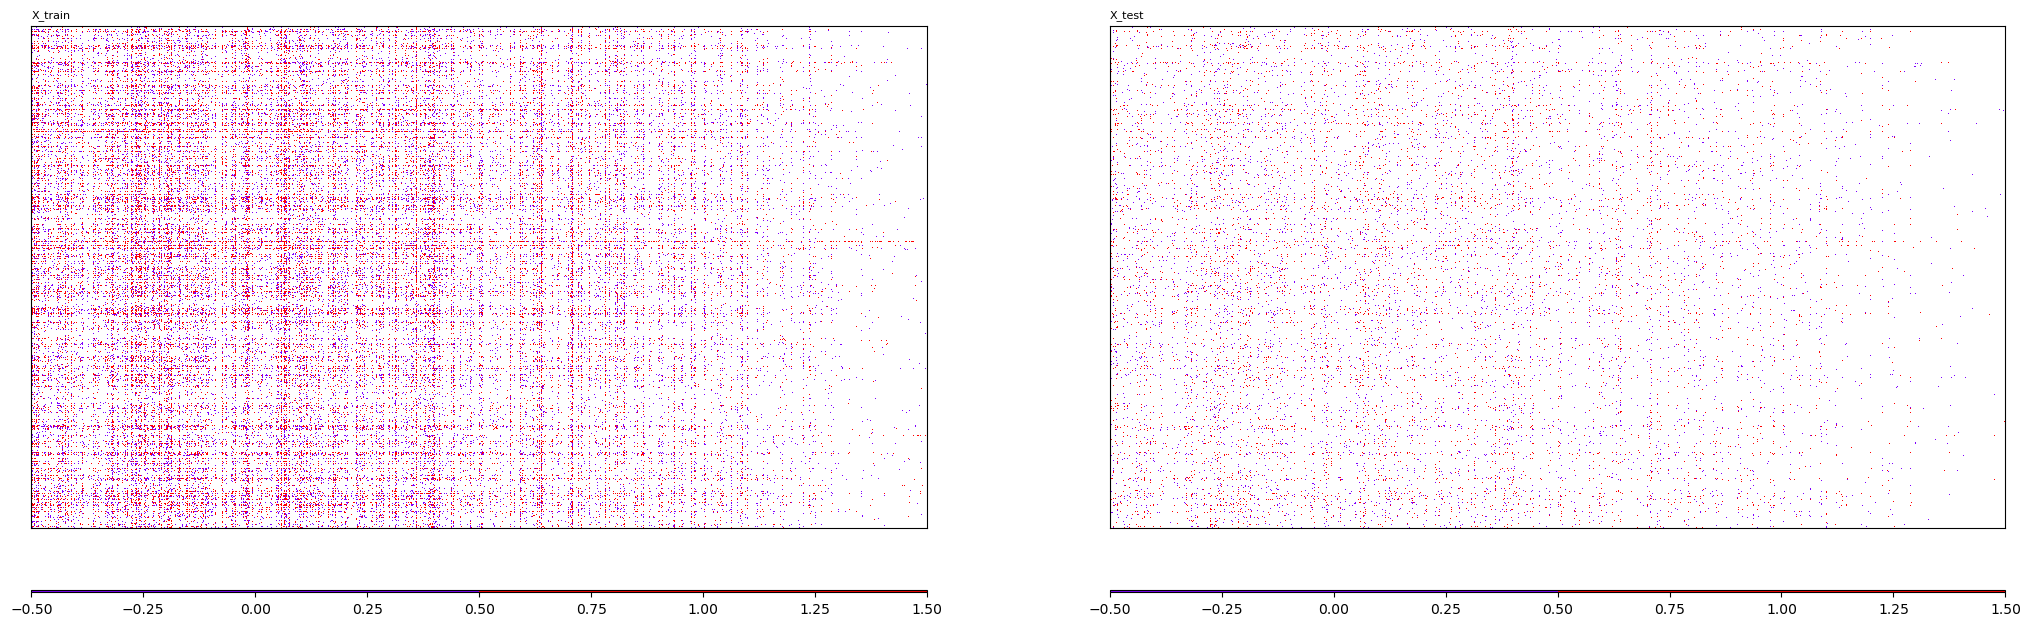

: 

In [40]:
settings = [(X_train, [0, 0], 'X_train'), (X_test, [0, 1], 'X_test')]
show_matrix(settings=settings, colorbar=True, cmap='rainbow', discrete=True, center=True, keep_nan=True)

In [26]:
def show_results(means=True):
    P = A @ B.T
    if means is True:
        for r in range(P.shape[0]):
            P[r, :] += a[r]
        for c in range(P.shape[1]):
            P[:, c] += b[c]
        P += miu

    rows, cols = X_train.tocoo().row, X_train.tocoo().col
    X_recover = np.empty(shape=X_train.shape)
    X_recover.fill(np.nan)
    for i in range(len(rows)):
        X_recover[rows[i], cols[i]] = P[rows[i], cols[i]]
    X_recover = csr_matrix(X_recover)

    rows, cols = X_test.tocoo().row, X_test.tocoo().col
    X_predict = np.empty(shape=X_test.shape)
    X_predict.fill(np.nan)
    for i in range(len(rows)):
        X_predict[rows[i], cols[i]] = P[rows[i], cols[i]]
    X_predict = csr_matrix(X_predict)

    rng = [200, 200]
    settings = [(X_train[:rng[0], :rng[1]], [0, 0], 'X_train'), 
                (X_recover[:rng[0], :rng[1]], [0, 1], 'X_recover'), 
                (X_test[:rng[0], :rng[1]], [1, 0], 'X_test'), 
                (X_predict[:rng[0], :rng[1]], [1, 1], 'X_predict'), 
                (P[:rng[0], :rng[1]], [0, 2], 'all predict')]
    show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

# cmf-1 (nonneg)

In [34]:
model = CMF(method="als", k=k, lambda_=lambda_, verbose=False, maxiter=maxiter, user_bias=False, item_bias=False, center=False, nonneg=True)
model.fit(X_train)

A, B = model.A_, model.B_
P = A @ B.T

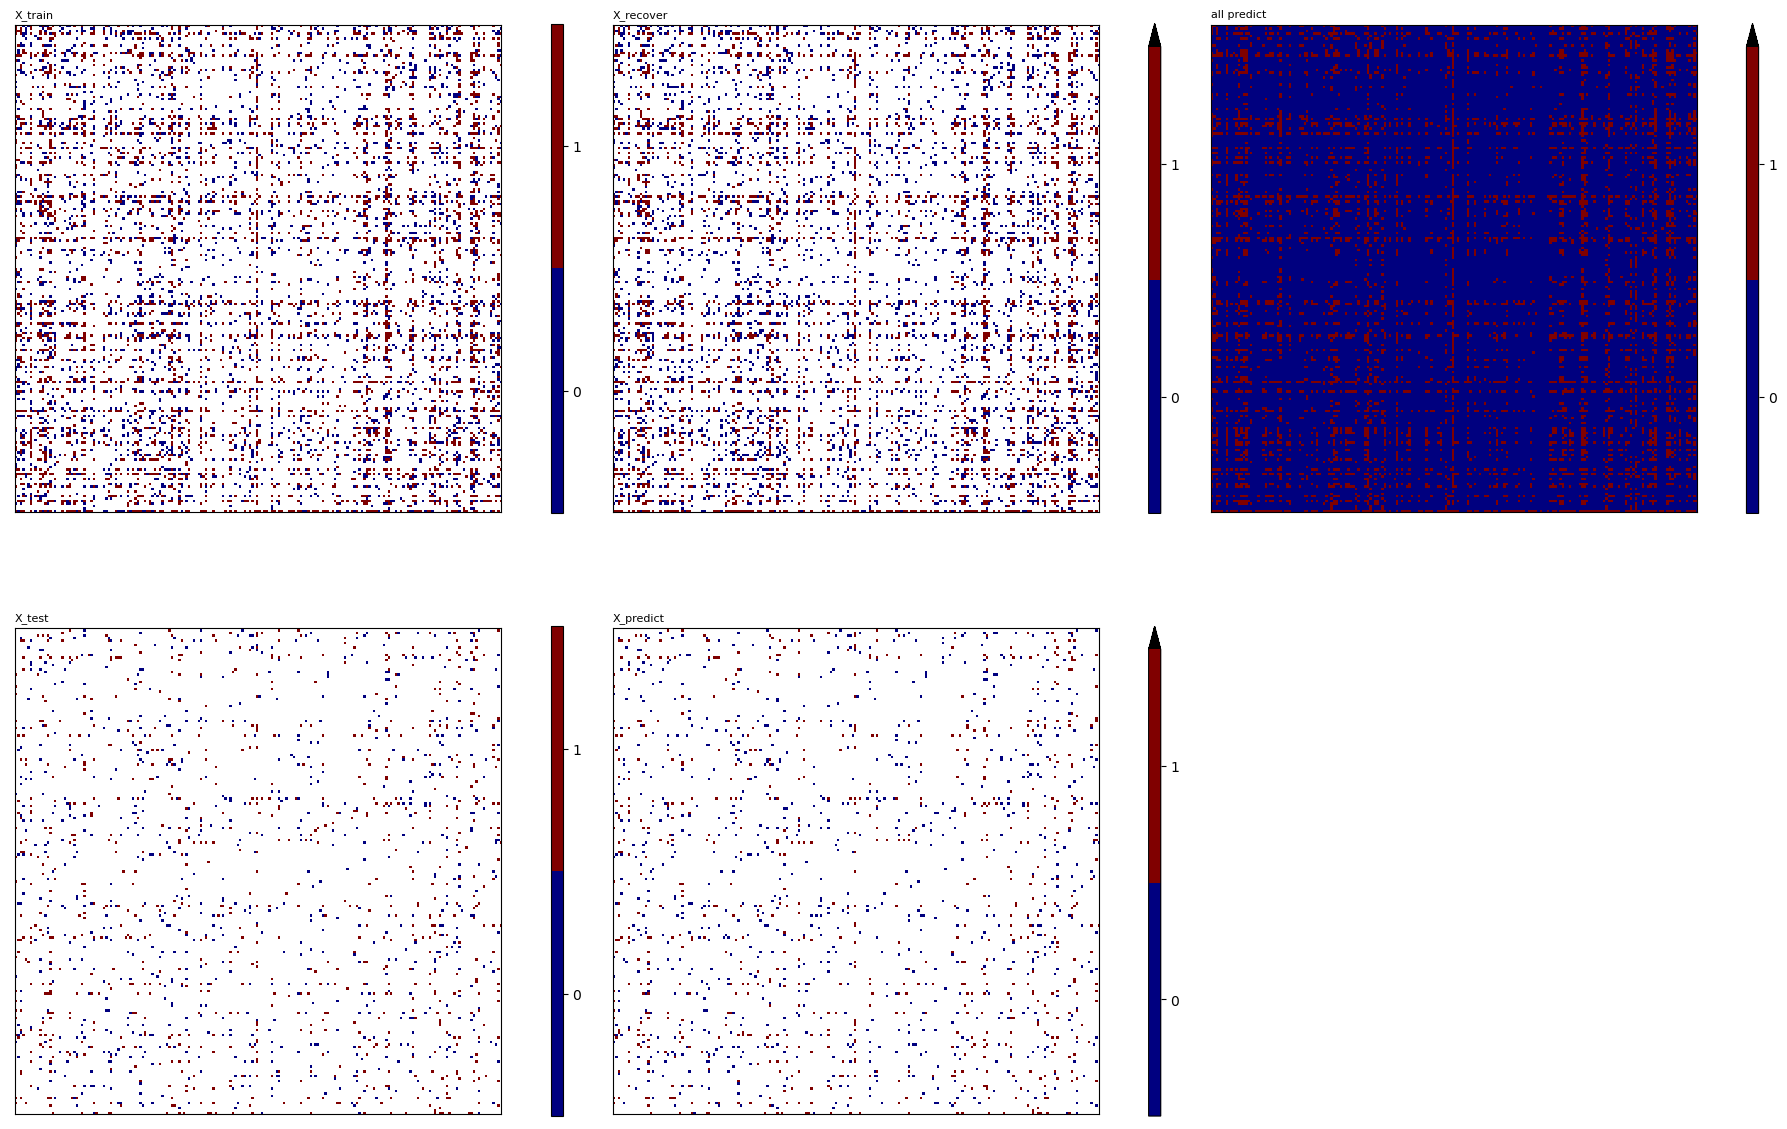

In [35]:
show_results(means=False)

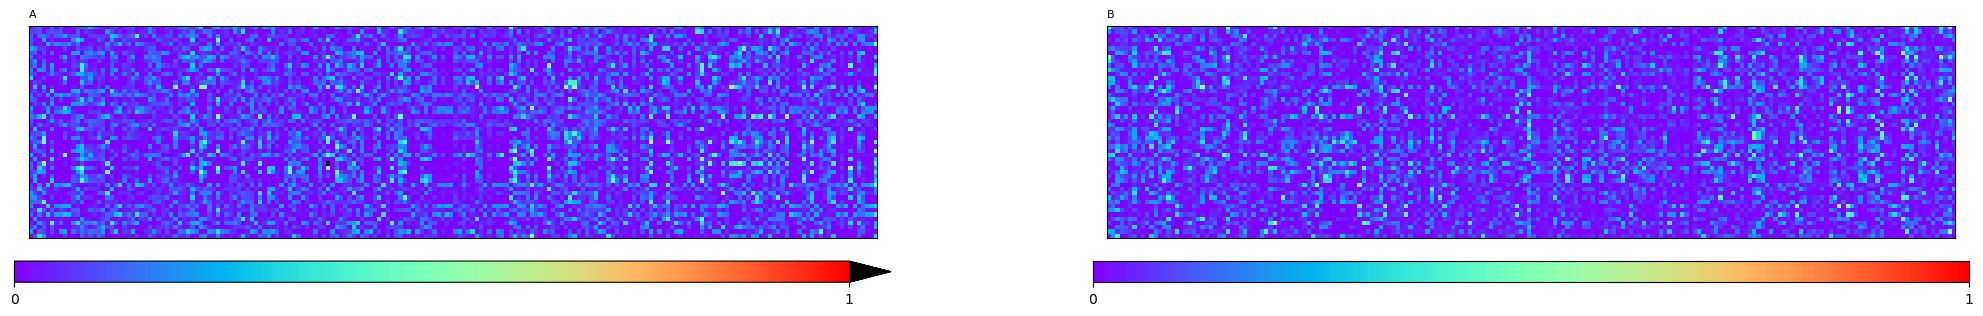

In [181]:
L = 200

settings = [(A[:L].T, [0, 0], 'A'), 
            (B[:L].T, [0, 1], 'B')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], cmap='rainbow', discrete=False, keep_nan=True)

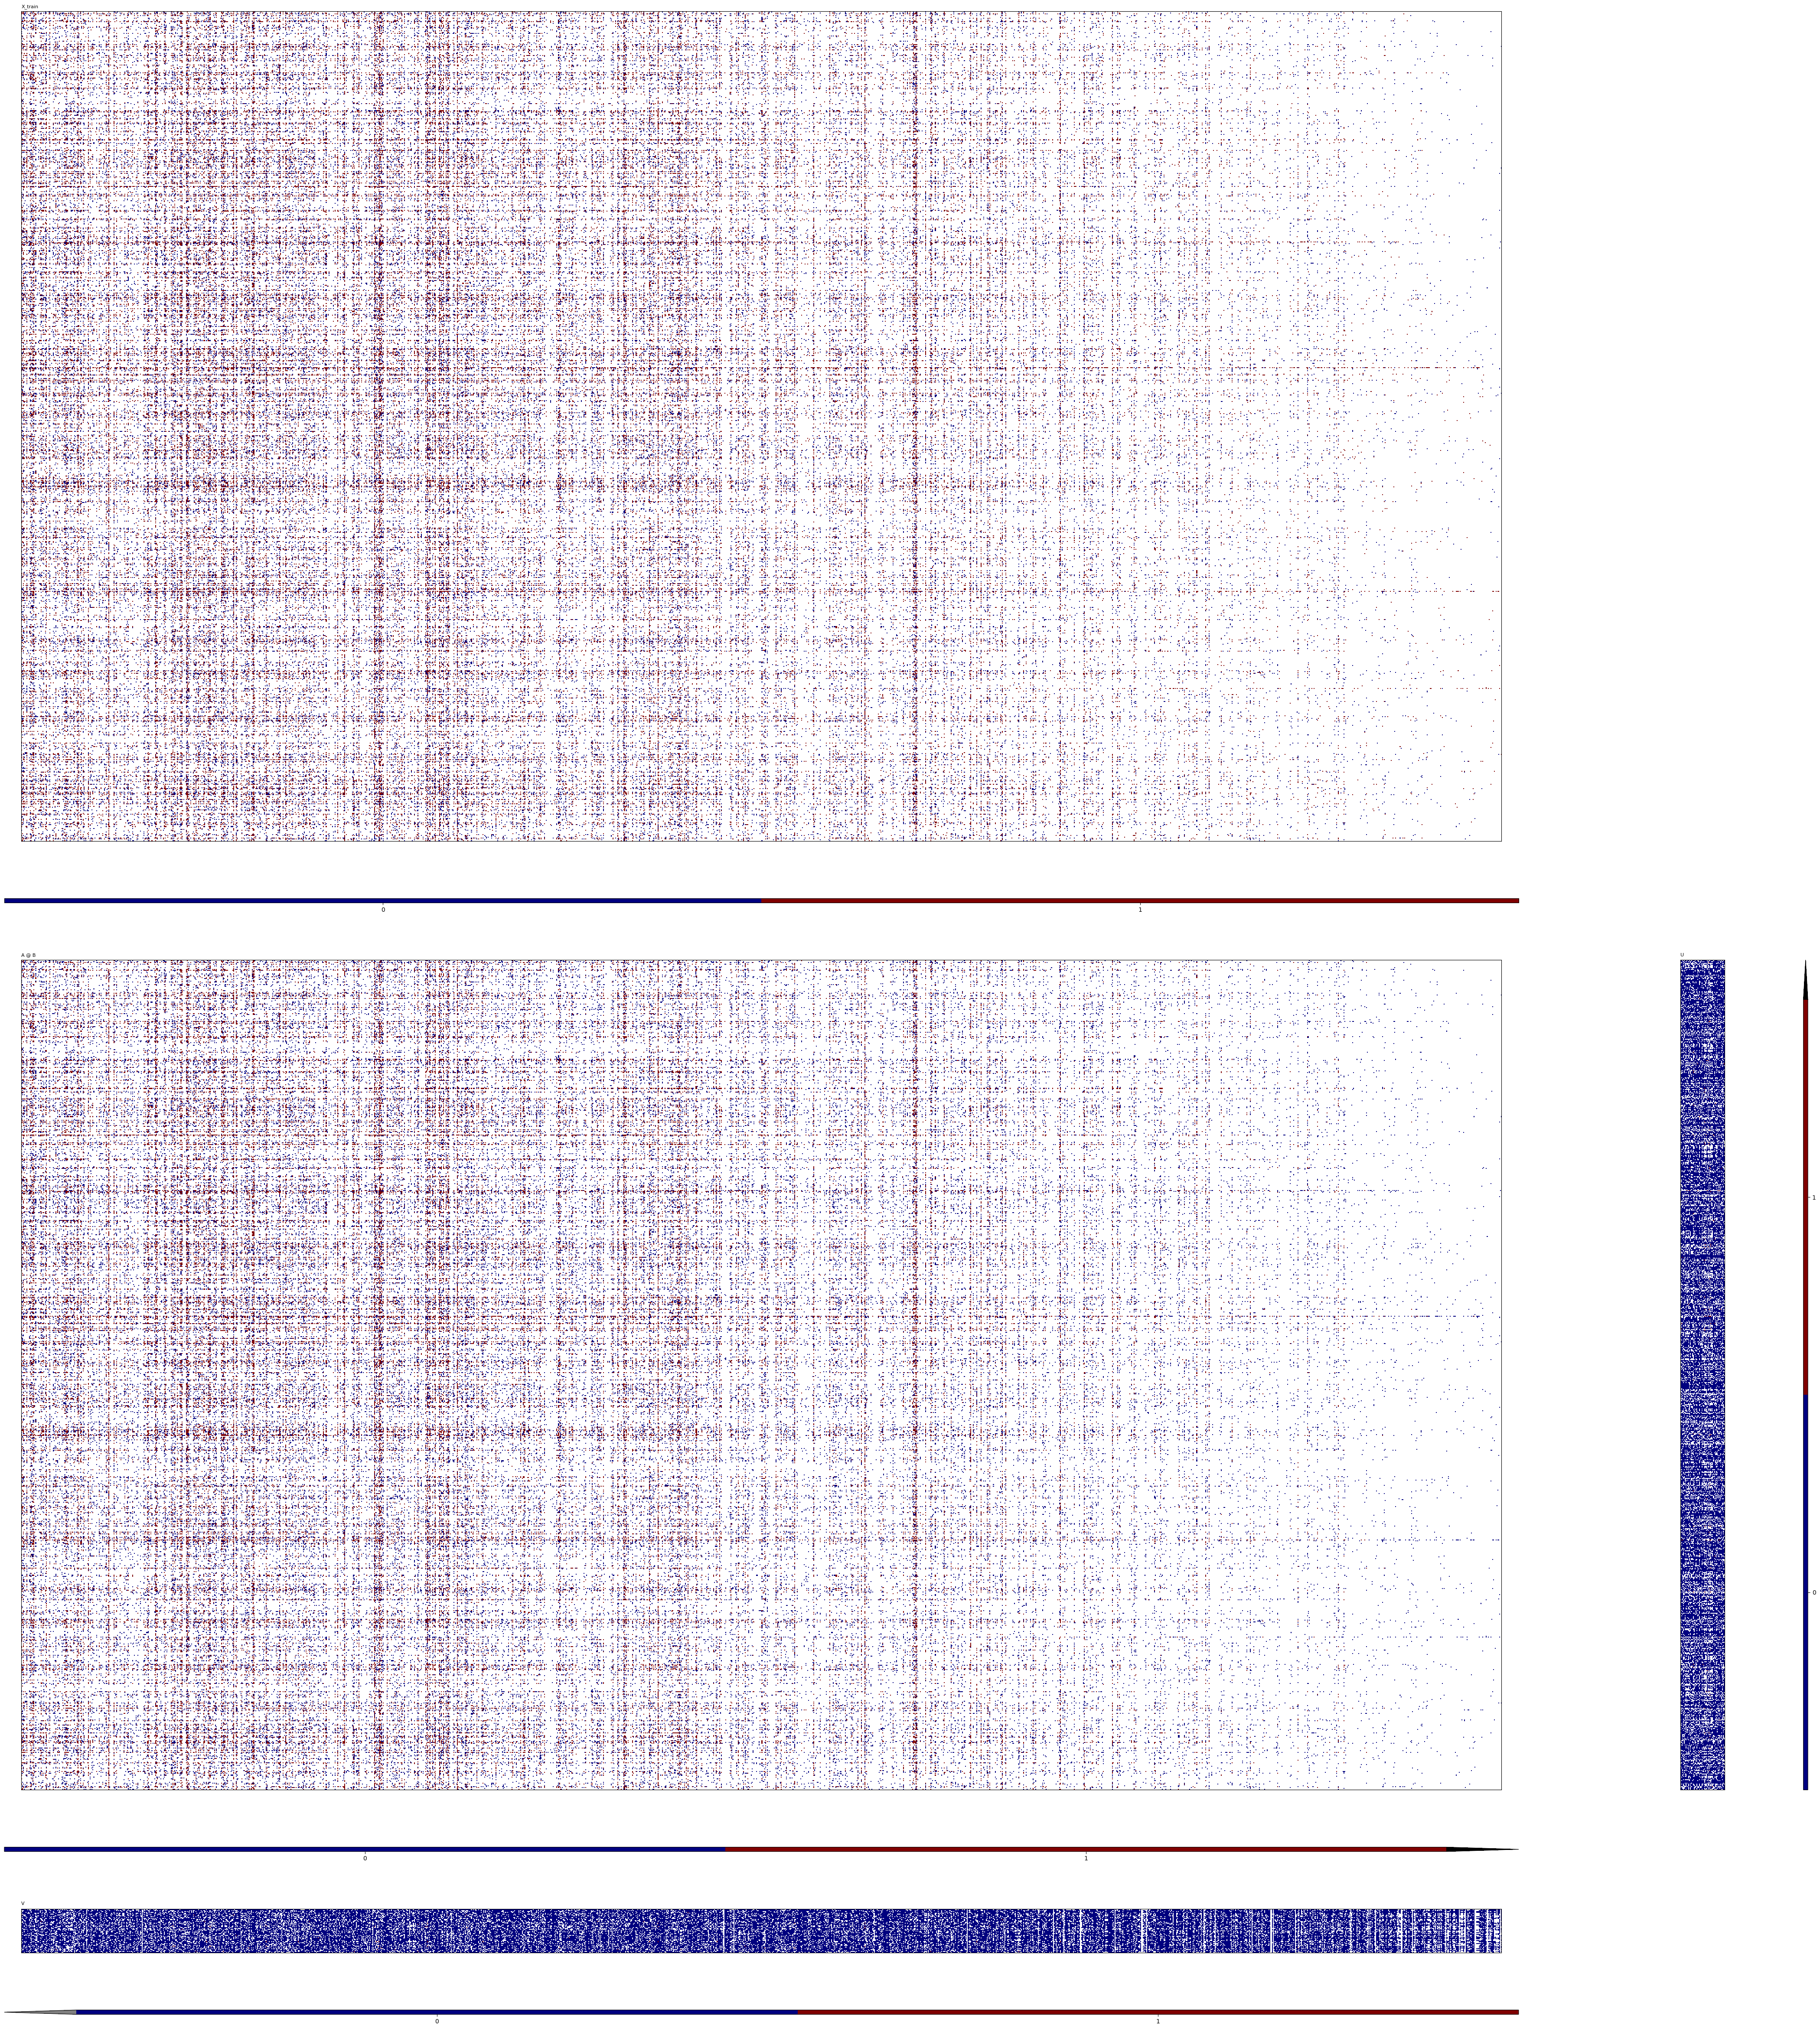

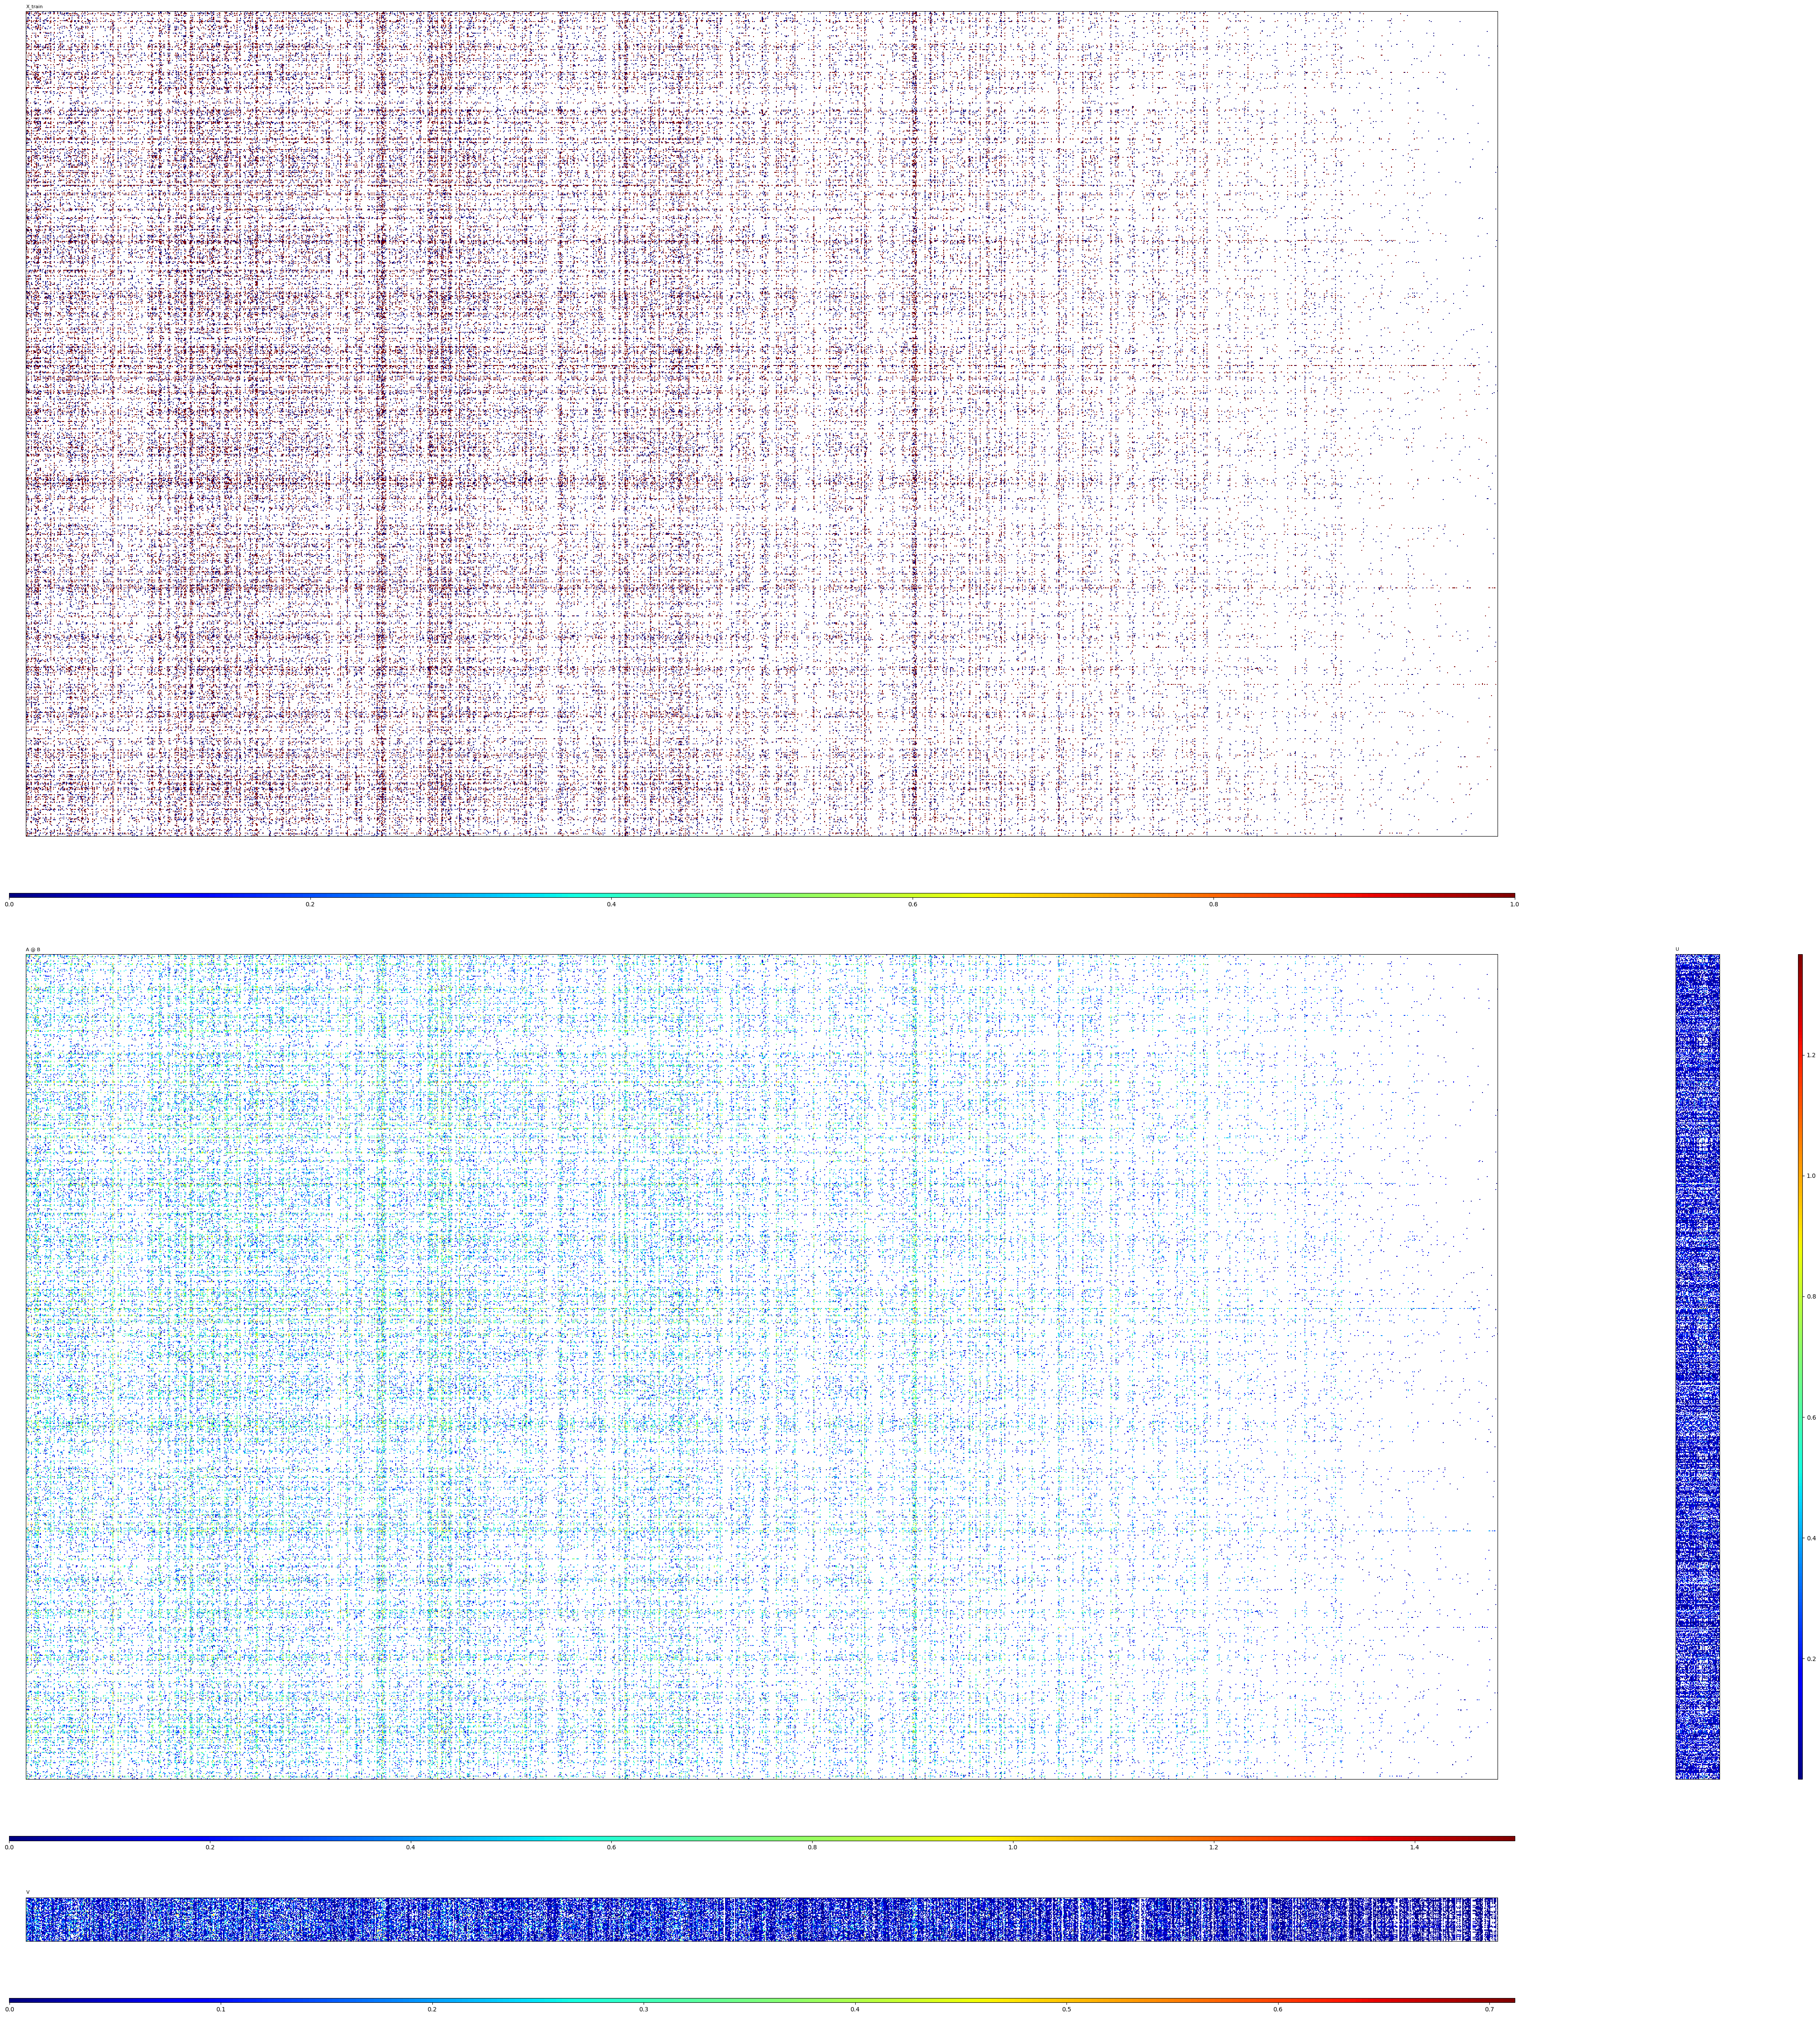

In [187]:
X_real = A @ B.T
# X_bool = matmul(bmf.U, bmf.V.T, sparse=True, boolean=True)

X = fill_nan(X_real, X_train)
V = B.T.copy()
V[V == 0] = np.nan
U = A.copy()
U[U == 0] = np.nan

L = 200

settings = [(X_train, [0, 0], 'X_train'), 
            (X, [1, 0], 'A @ B'), 
            (V, [2, 0], 'V'), 
            (U, [1, 1], 'U')
            ]
show_matrix(settings=settings, scaling=1, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)
show_matrix(settings=settings, scaling=1, colorbar=True, discrete=False, keep_nan=True)

# BMFThreshold

In [217]:
bmf = BinaryMFThreshold(k=k, u=0.2, v=0.2, lamda=10, eps=1e-6, max_iter=200)
bmf.fit(X_train)

[I] k            : 50
[I] algorithm    : threshold
[I] initial u, v : [0.2, 0.2]
[I] lamda        : 10
[I] eps          : 1e-06
[I] max_iter     : 200
[I] rescale      : 1
[W] Missing validation data.
[I] k            : 50
[I] seed         : 1705442004
[I] init         : random
[I] max_iter     : 1000
[W] Missing validation data.
[I] After initialization: max U: 19.421, max V: 22.062
[I] After normalization: max U: 1.363, max V: 1.363
[W] Normalization failed. Re-try will help.
[I] iter: 0, start from [0.200, 0.200], search direction [0.672, 0.740]
[I] iter: 1, start from [0.872, 0.940], search direction [-0.893, -0.451]
[I] iter: 2, start from [0.426, 0.715], search direction [0.784, -0.621]
[I] iter: 3, start from [0.445, 0.700], search direction [-0.820, -0.572]
[W] Stopped in advance: search direction is not a descent direction.


c:\Users\nieht\Anaconda3\envs\cornac\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


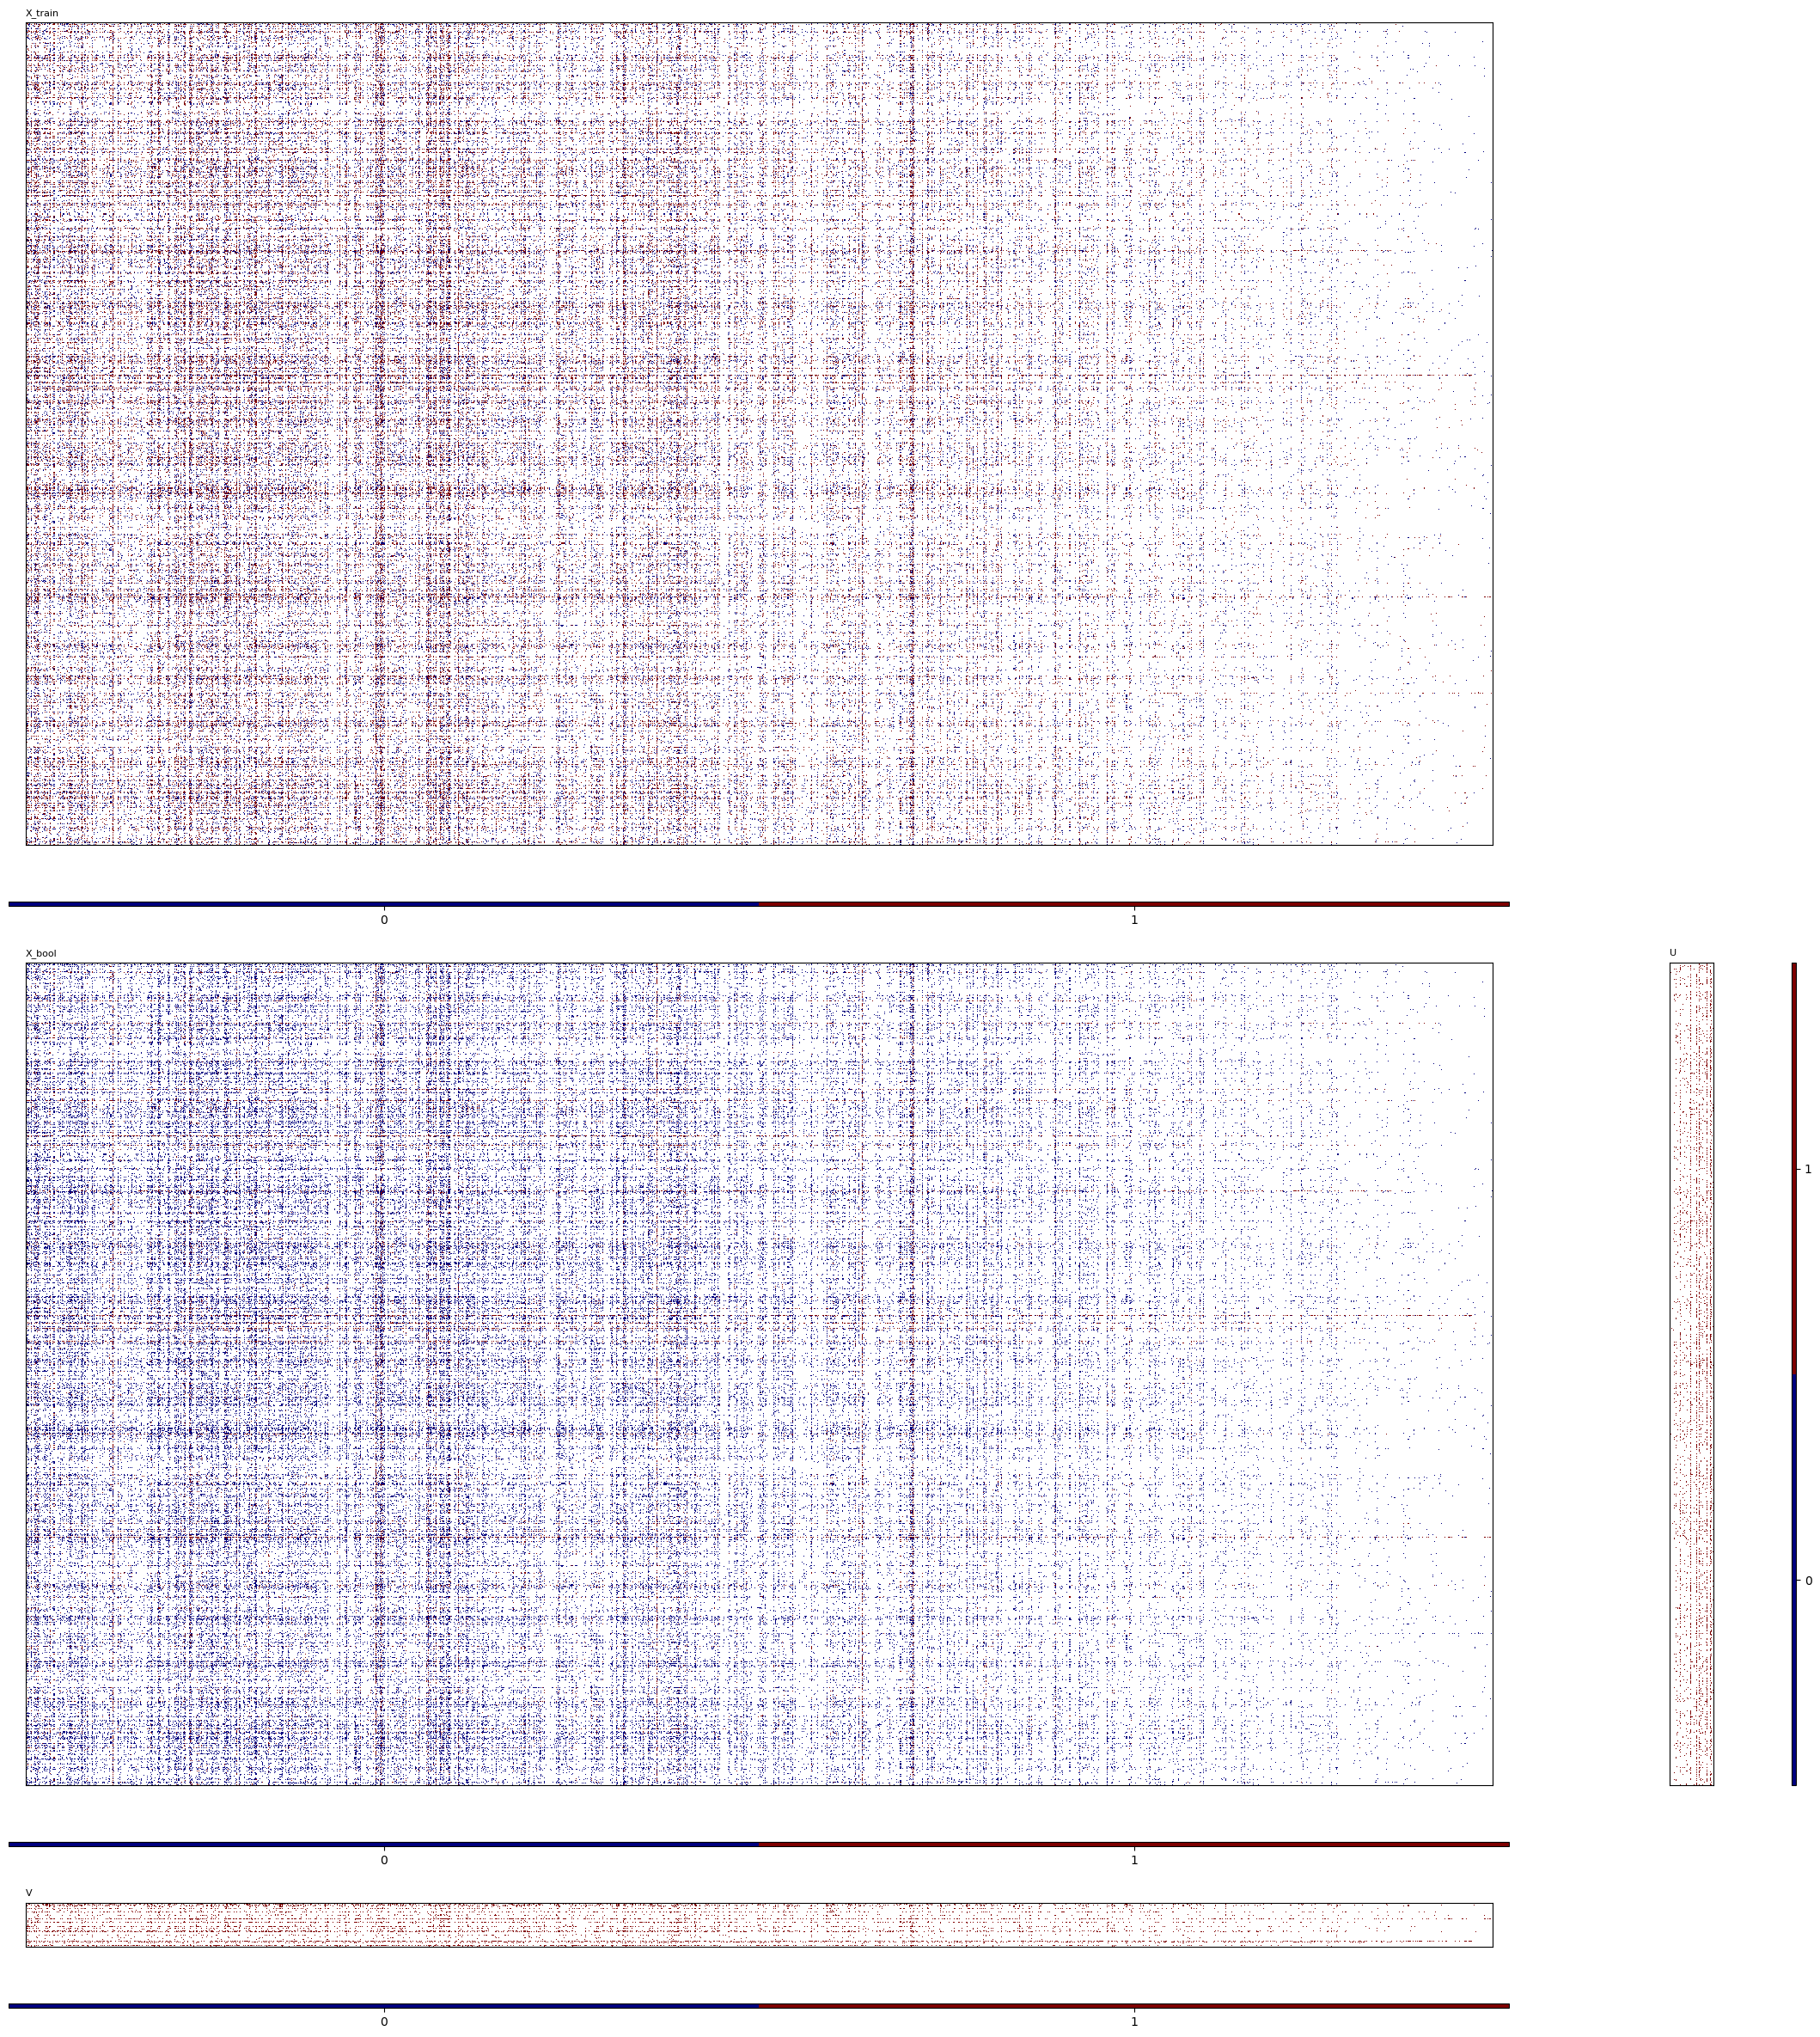

In [127]:
X_real = bmf.U @ bmf.V.T
X_bool = matmul(bmf.U, bmf.V.T, sparse=True, boolean=True)

X = fill_nan(X_bool, X_train)
V = bmf.V.T.copy()
V[V == 0] = np.nan
U = bmf.U.copy()
U[U == 0] = np.nan

L = 200

settings = [(X_train, [0, 0], 'X_train'), 
            (X, [1, 0], 'X_bool'), 
            (V, [2, 0], 'V'), 
            (U, [1, 1], 'U')]
show_matrix(settings=settings, scaling=2, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

# cmf-1, BMFThreshold

In [11]:
model = CMF(method="als", k=k, lambda_=lambda_, verbose=False, maxiter=maxiter, user_bias=False, item_bias=False, center=False, nonneg=True)
model.fit(X_train)

A, B = model.A_, model.B_
P = A @ B.T
A.min(), A.max(), B.min(), B.max()

(0.0, 1.4961365, 0.0, 0.7254627)

In [25]:
bmf = BinaryMFThresholdExCustomFactors(U=A, V=B, u=0.5, v=0.5, lamda=10, eps=1e-6, max_iter=200)
bmf.fit(X_train)

[I] algorithm    : threshold
[I] initial u, v : [0.5, 0.5]
[I] lamda        : 10
[I] eps          : 1e-06
[I] max_iter     : 200
[W] Missing validation data.
[I] After initialization: max U: 1.496, max V: 0.725
[I] After normalization: max U: 0.825, max V: 0.825
[I] iter: 0, start from [0.500, 0.500], search direction [-0.687, -0.727]
[I] iter: 1, start from [0.367, 0.359], search direction [0.757, 0.653]
[W] Stopped in advance: search direction is not a descent direction.


### diagnosis

In [252]:
bmf = BinaryMFThresholdExCustomFactors(U=A, V=B, u=0.5, v=0.5, lamda=10, eps=1e-6, max_iter=200)
bmf.fit(X_train)

[I] algorithm    : threshold
[I] initial u, v : [0.5, 0.5]
[I] lamda        : 10
[I] eps          : 1e-06
[I] max_iter     : 200
[W] Missing validation data.
[I] After initialization: max U: 1.366, max V: 0.712
[I] After normalization: max U: 0.805, max V: 0.805


100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


Text(0.5, 0, 'z')

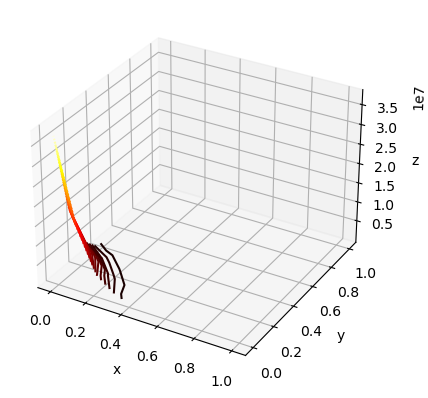

In [16]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

N = 10
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
Z = np.zeros([N, N])
X, Y = np.meshgrid(x, y)
for i in tqdm(range(N)):
    for j in range(N):
        Z[i, j] = bmf.F([X[i, j], Y[i, j]])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='hot')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

100%|██████████| 10/10 [00:02<00:00,  4.45it/s]


Text(0.5, 0, 'z')

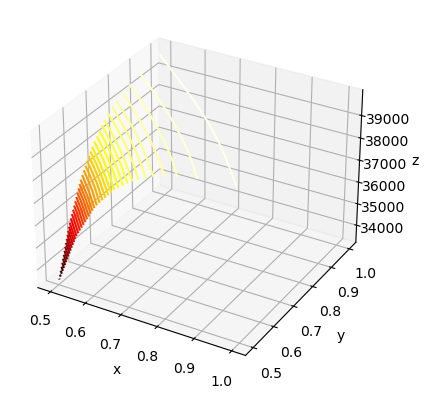

In [17]:
N = 10
x = np.linspace(0.5, 1, N)
y = np.linspace(0.5, 1, N)
Z = np.zeros([N, N])
X, Y = np.meshgrid(x, y)
for i in tqdm(range(N)):
    for j in range(N):
        Z[i, j] = bmf.F([X[i, j], Y[i, j]])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='hot')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

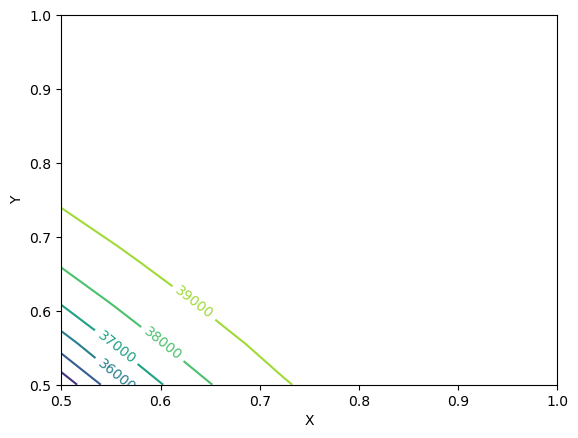

In [18]:
cp = plt.contour(X, Y, Z)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### binarize

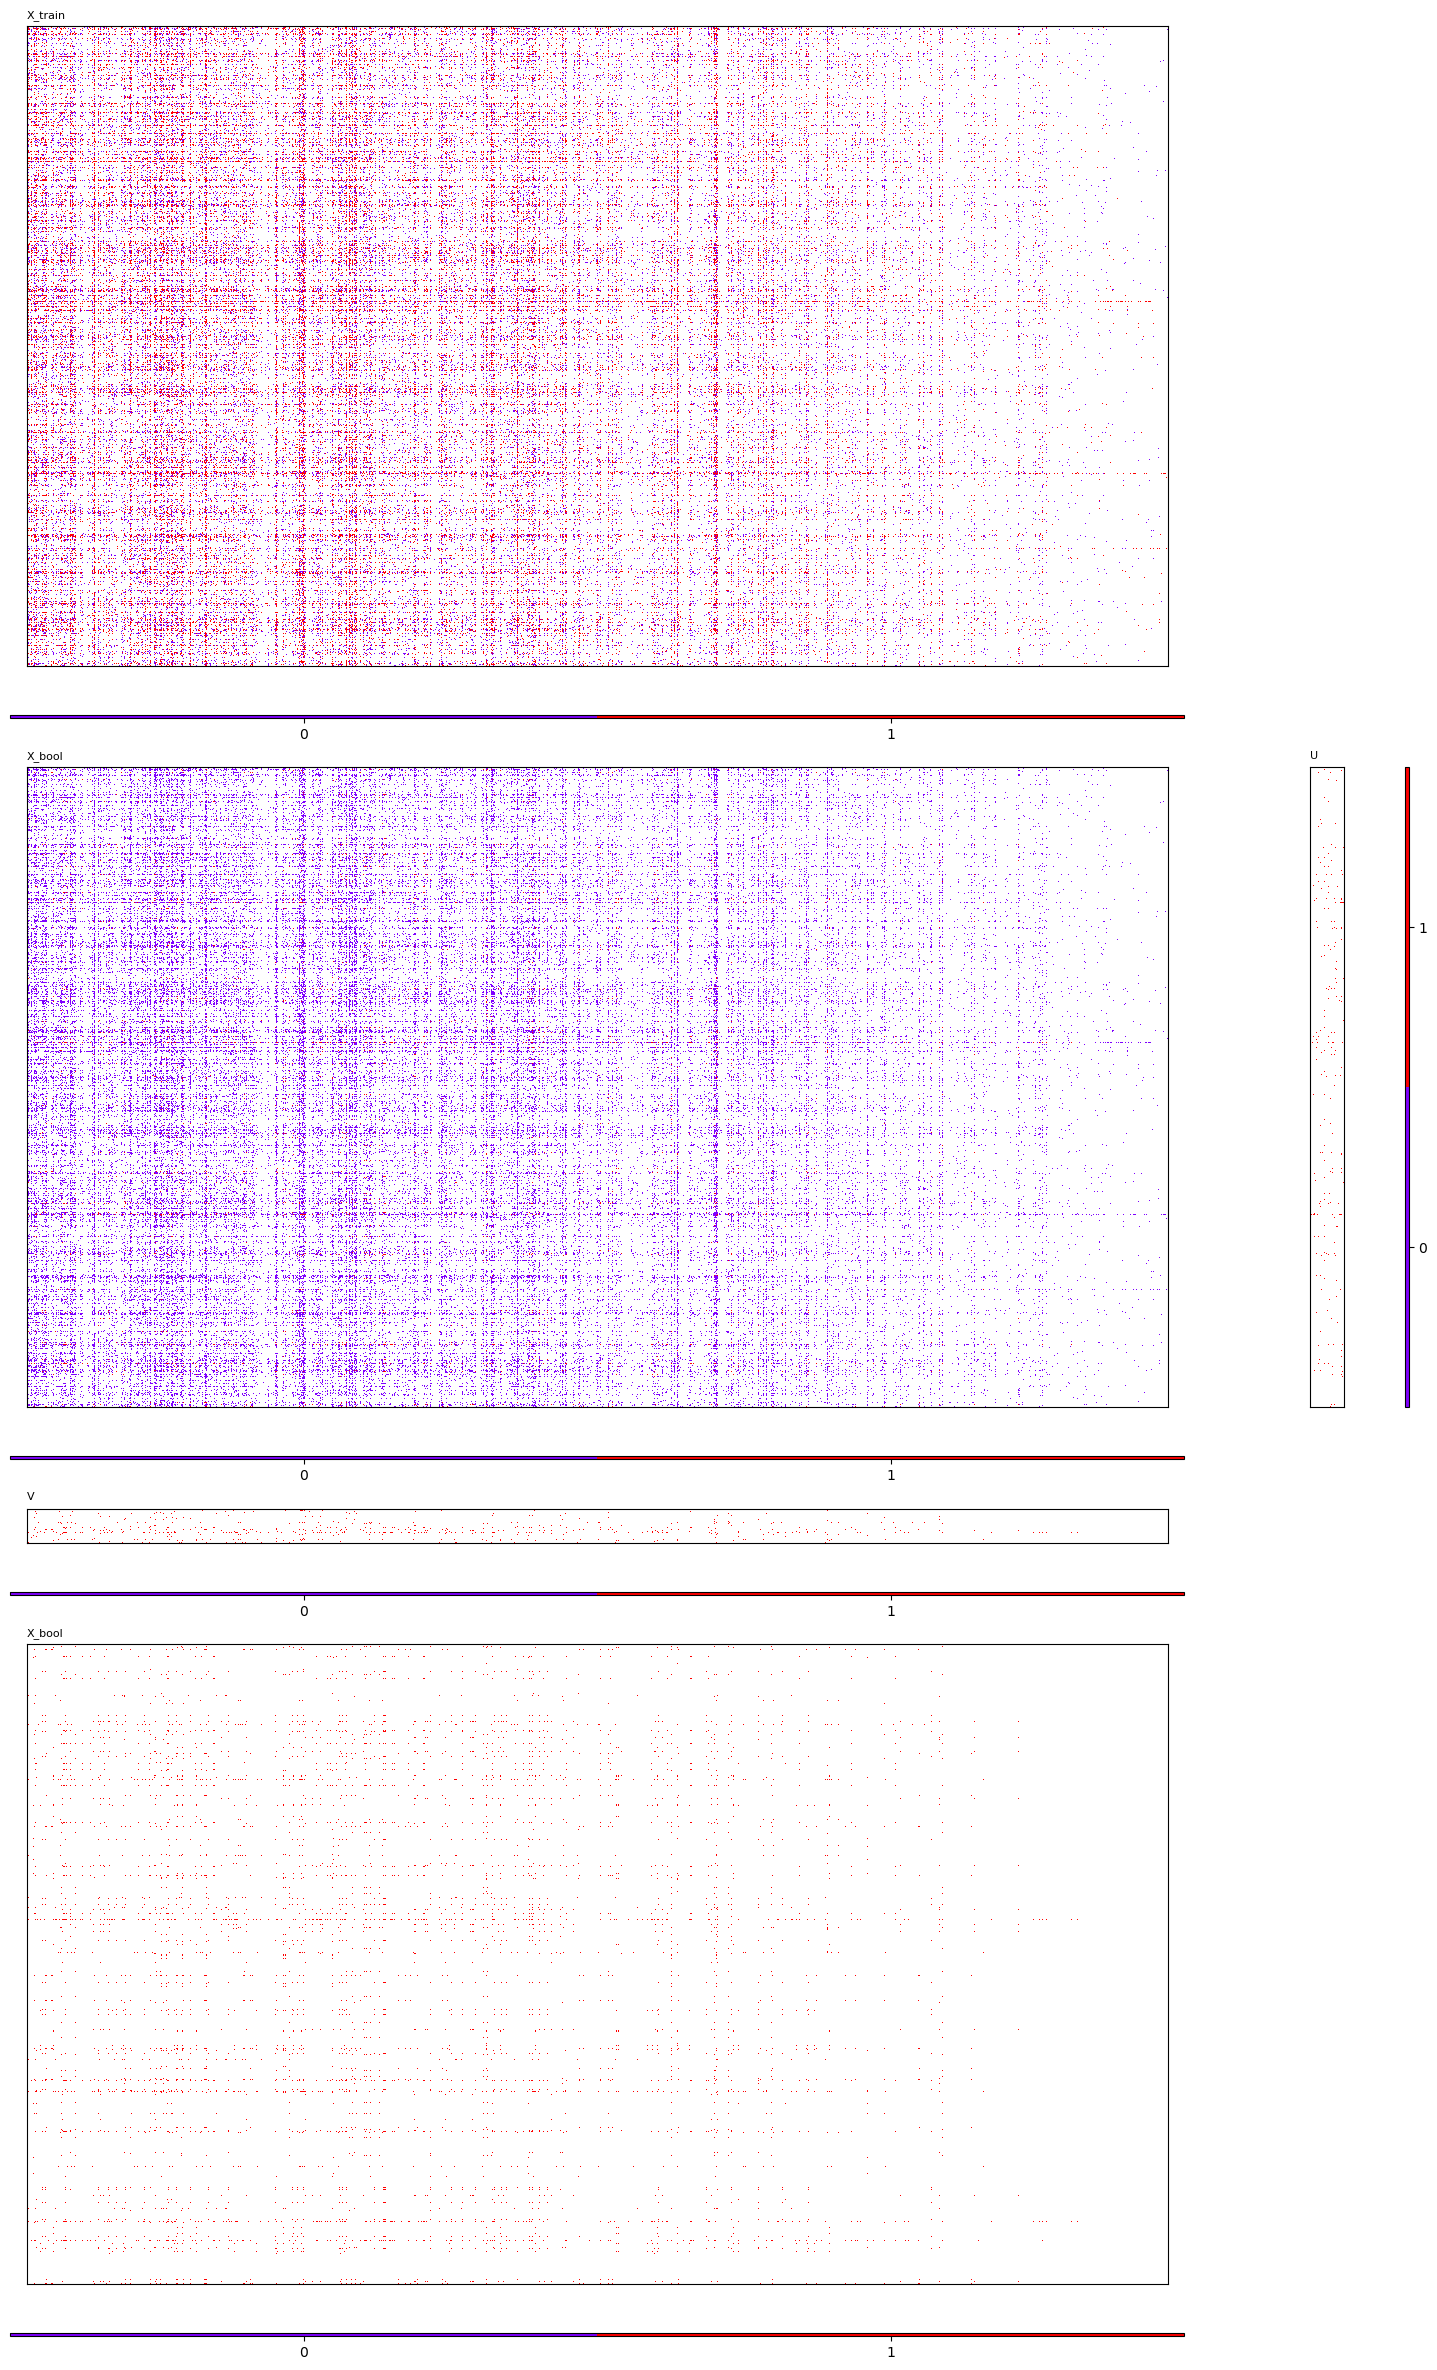

In [22]:
# X_real = bmf.U @ bmf.V.T
X_bool = matmul(bmf.U, bmf.V.T, sparse=True, boolean=True)

X = fill_nan(X_bool, X_train)
V = bmf.V.T.copy()
V[V == 0] = np.nan
U = bmf.U.copy()
U[U == 0] = np.nan

L = 200

settings = [(X_train, [0, 0], 'X_train'), 
            (X, [1, 0], 'X_bool'), 
            (V, [2, 0], 'V'), 
            (U, [1, 1], 'U'), 
            (X_bool, [3, 0], 'X_bool')]
show_matrix(settings=settings, scaling=2, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True, cmap='rainbow')

# cmf-3, als

In [38]:
model = CMF(method="als", k=k, lambda_=lambda_, w_main=0.5, w_user=0.25, w_item=0.25, verbose=False, user_bias=False, item_bias=False, center=False, nonneg=True, nonneg_C=True, nonneg_D=True)
model.fit(X=X_train, U=Y, I=Z.T)

A, B = model.A_, model.B_
P = A @ B.T

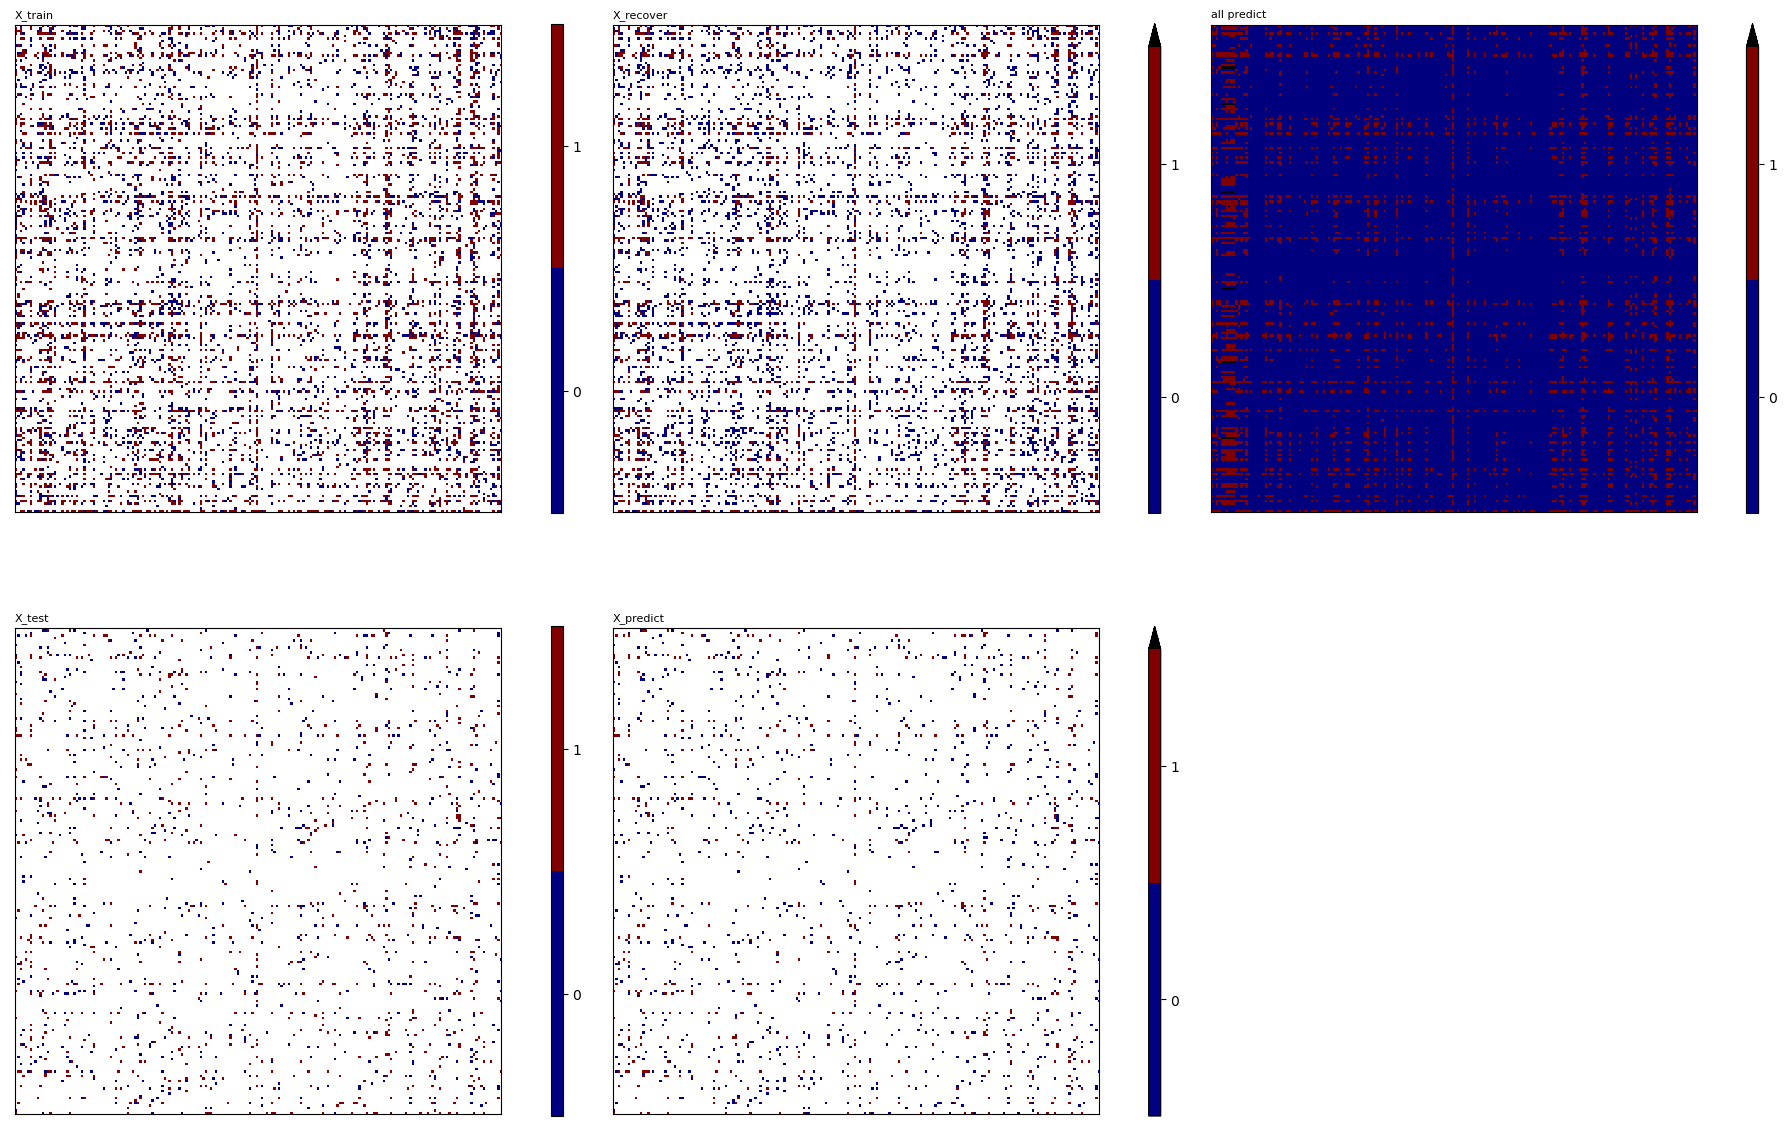

In [39]:
show_results(means=False)

In [45]:
A, B, C, D = model.A_, model.B_, model.C_, model.D_
(A.min(), A.max()), (B.min(), B.max())

((0.0, 0.58762413), (0.0, 50.99108))

In [50]:
bmf = BinaryMFThresholdExCustomFactors(U=A, V=B, u=0.5, v=0.5, lamda=10, eps=1e-6, max_iter=200)
bmf.fit(X_train, verbose=True, display=False)

[I] algorithm    : threshold
[I] initial u, v : [0.5, 0.5]
[I] lamda        : 10
[I] eps          : 1e-06
[I] max_iter     : 200
[I] verbose      : True
[I] display      : False
[W] Missing validation data.
[I] After initialization: max U: 0.588, max V: 50.991
[I] After normalization: max U: 2.090, max V: 2.090
[W] Normalization failed. Re-try will help.
[I] iter: 0, start from [0.500, 0.500], search direction [-0.708, -0.706]
[I] [I] Wolfe line search for iter   : 0
[I]     num of function evals made   : 8
[I]     num of gradient evals made   : 3
[I]     function value update        : 37430.344 -> 16897.767
[I]     threshold update             : [0.500, 0.500] -> [0.334, 0.334]
[I]     threshold difference         : 0.235
[I] iter: 1, start from [0.334, 0.334], search direction [0.833, 0.553]
[I] [I] Wolfe line search for iter   : 1
[I]     num of function evals made   : 8
[I]     num of gradient evals made   : 1
[I]     function value update        : 16897.767 -> 16893.815
[I]     th

c:\Users\nieht\Anaconda3\envs\cornac\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


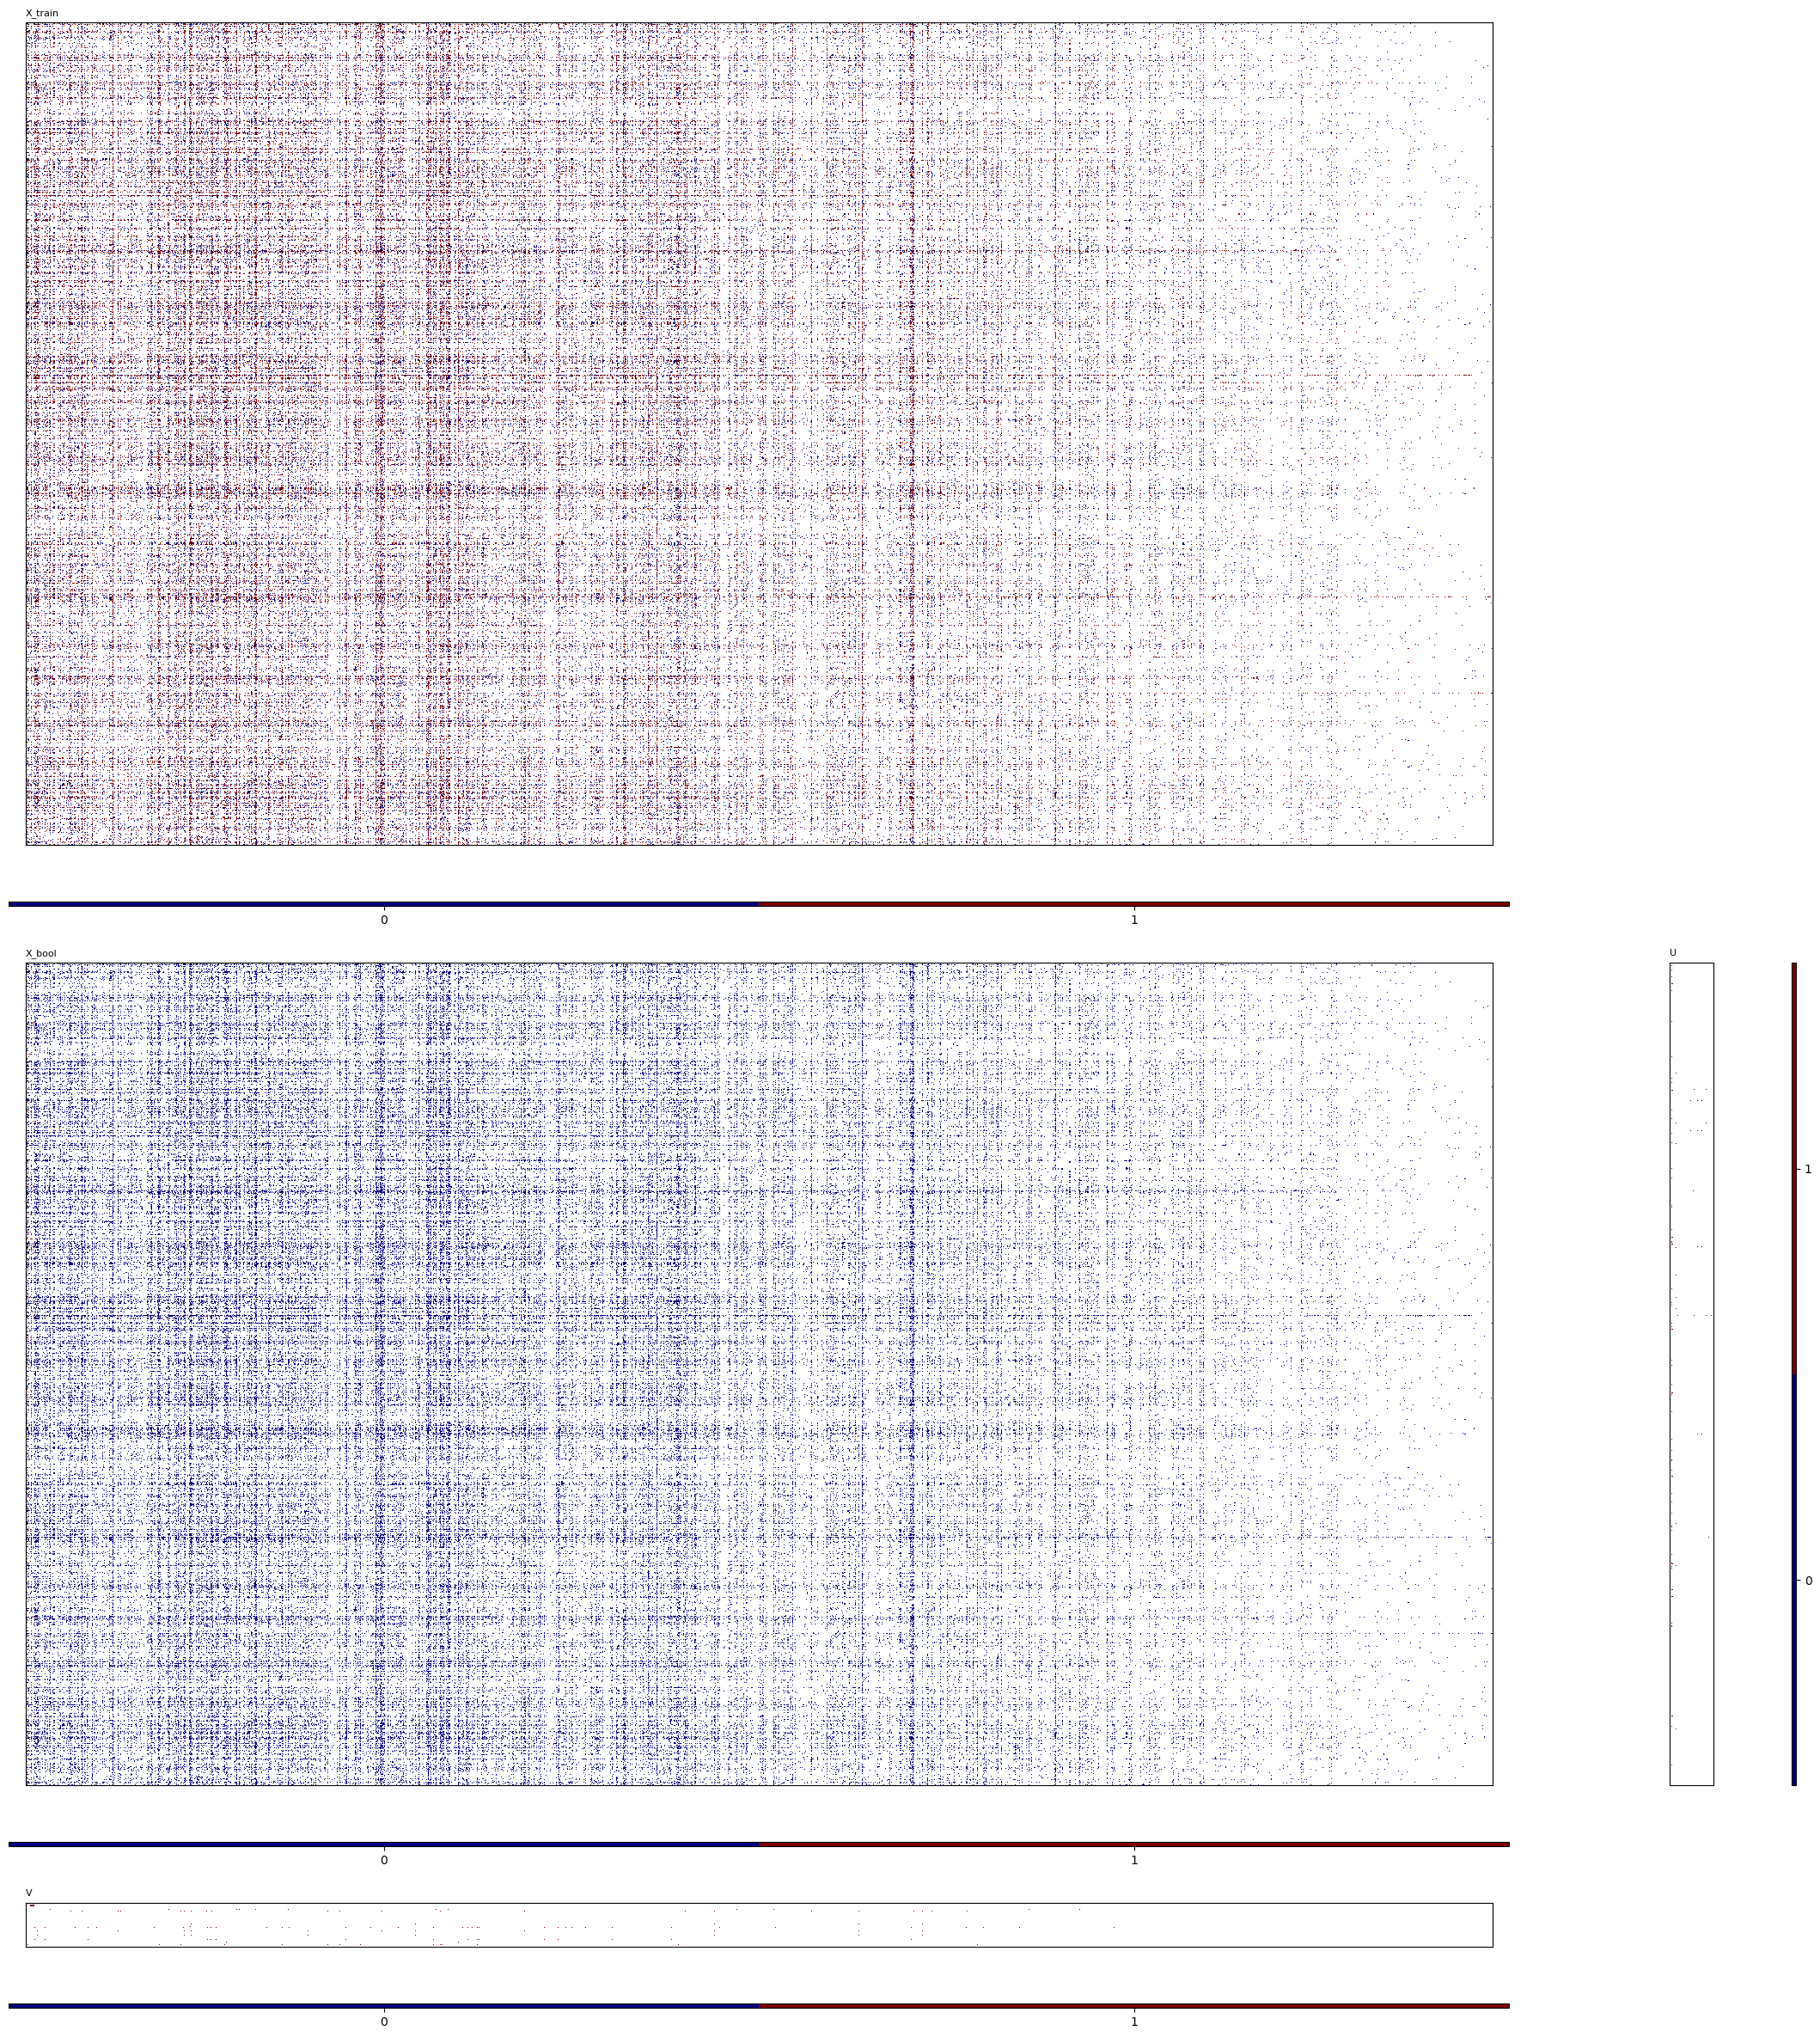

In [44]:
X_real = bmf.U @ bmf.V.T
X_bool = matmul(bmf.U, bmf.V.T, sparse=True, boolean=True)

X = fill_nan(X_bool, X_train)
V = bmf.V.T.copy()
V[V == 0] = np.nan
U = bmf.U.copy()
U[U == 0] = np.nan

L = 200

settings = [(X_train, [0, 0], 'X_train'), 
            (X, [1, 0], 'X_bool'), 
            (V, [2, 0], 'V'), 
            (U, [1, 1], 'U')]
show_matrix(settings=settings, scaling=2, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

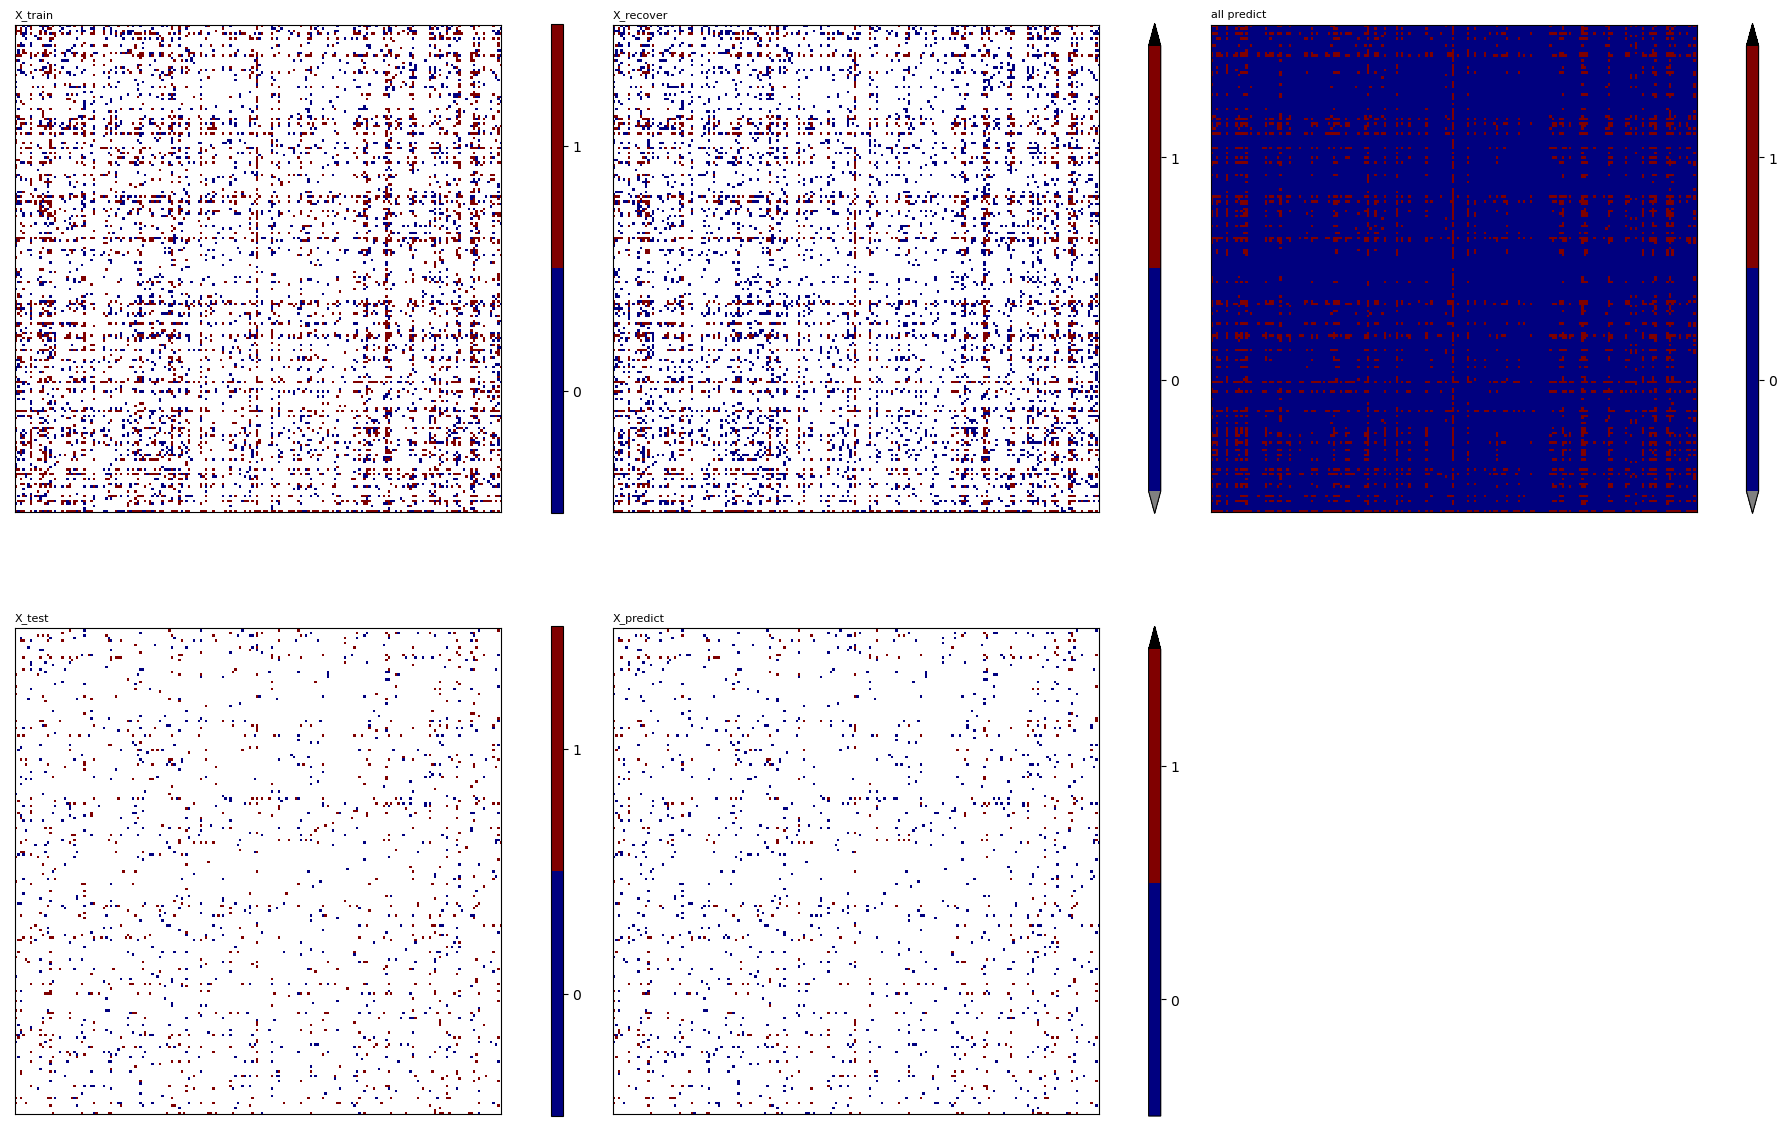

In [21]:
A, B, C, D = model.A_, model.B_, model.C_, model.D_
P = A @ B.T
Q = A @ C.T # user
R = D @ B.T # item

rows, cols = X_train.tocoo().row, X_train.tocoo().col
X_recover = np.empty(shape=X_train.shape)
X_recover.fill(np.nan)
for i in range(len(rows)):
    X_recover[rows[i], cols[i]] = P[rows[i], cols[i]]
X_recover = csr_matrix(X_recover)

rows, cols = X_test.tocoo().row, X_test.tocoo().col
X_predict = np.empty(shape=X_test.shape)
X_predict.fill(np.nan)
for i in range(len(rows)):
    X_predict[rows[i], cols[i]] = P[rows[i], cols[i]]
X_predict = csr_matrix(X_predict)

rng = [200, 200]
settings = [(X_train[:rng[0], :rng[1]], [0, 0], 'X_train'), 
            (X_recover[:rng[0], :rng[1]], [0, 1], 'X_recover'), 
            (X_test[:rng[0], :rng[1]], [1, 0], 'X_test'), 
            (X_predict[:rng[0], :rng[1]], [1, 1], 'X_predict'), 
            (P[:rng[0], :rng[1]], [0, 2], 'all predict')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

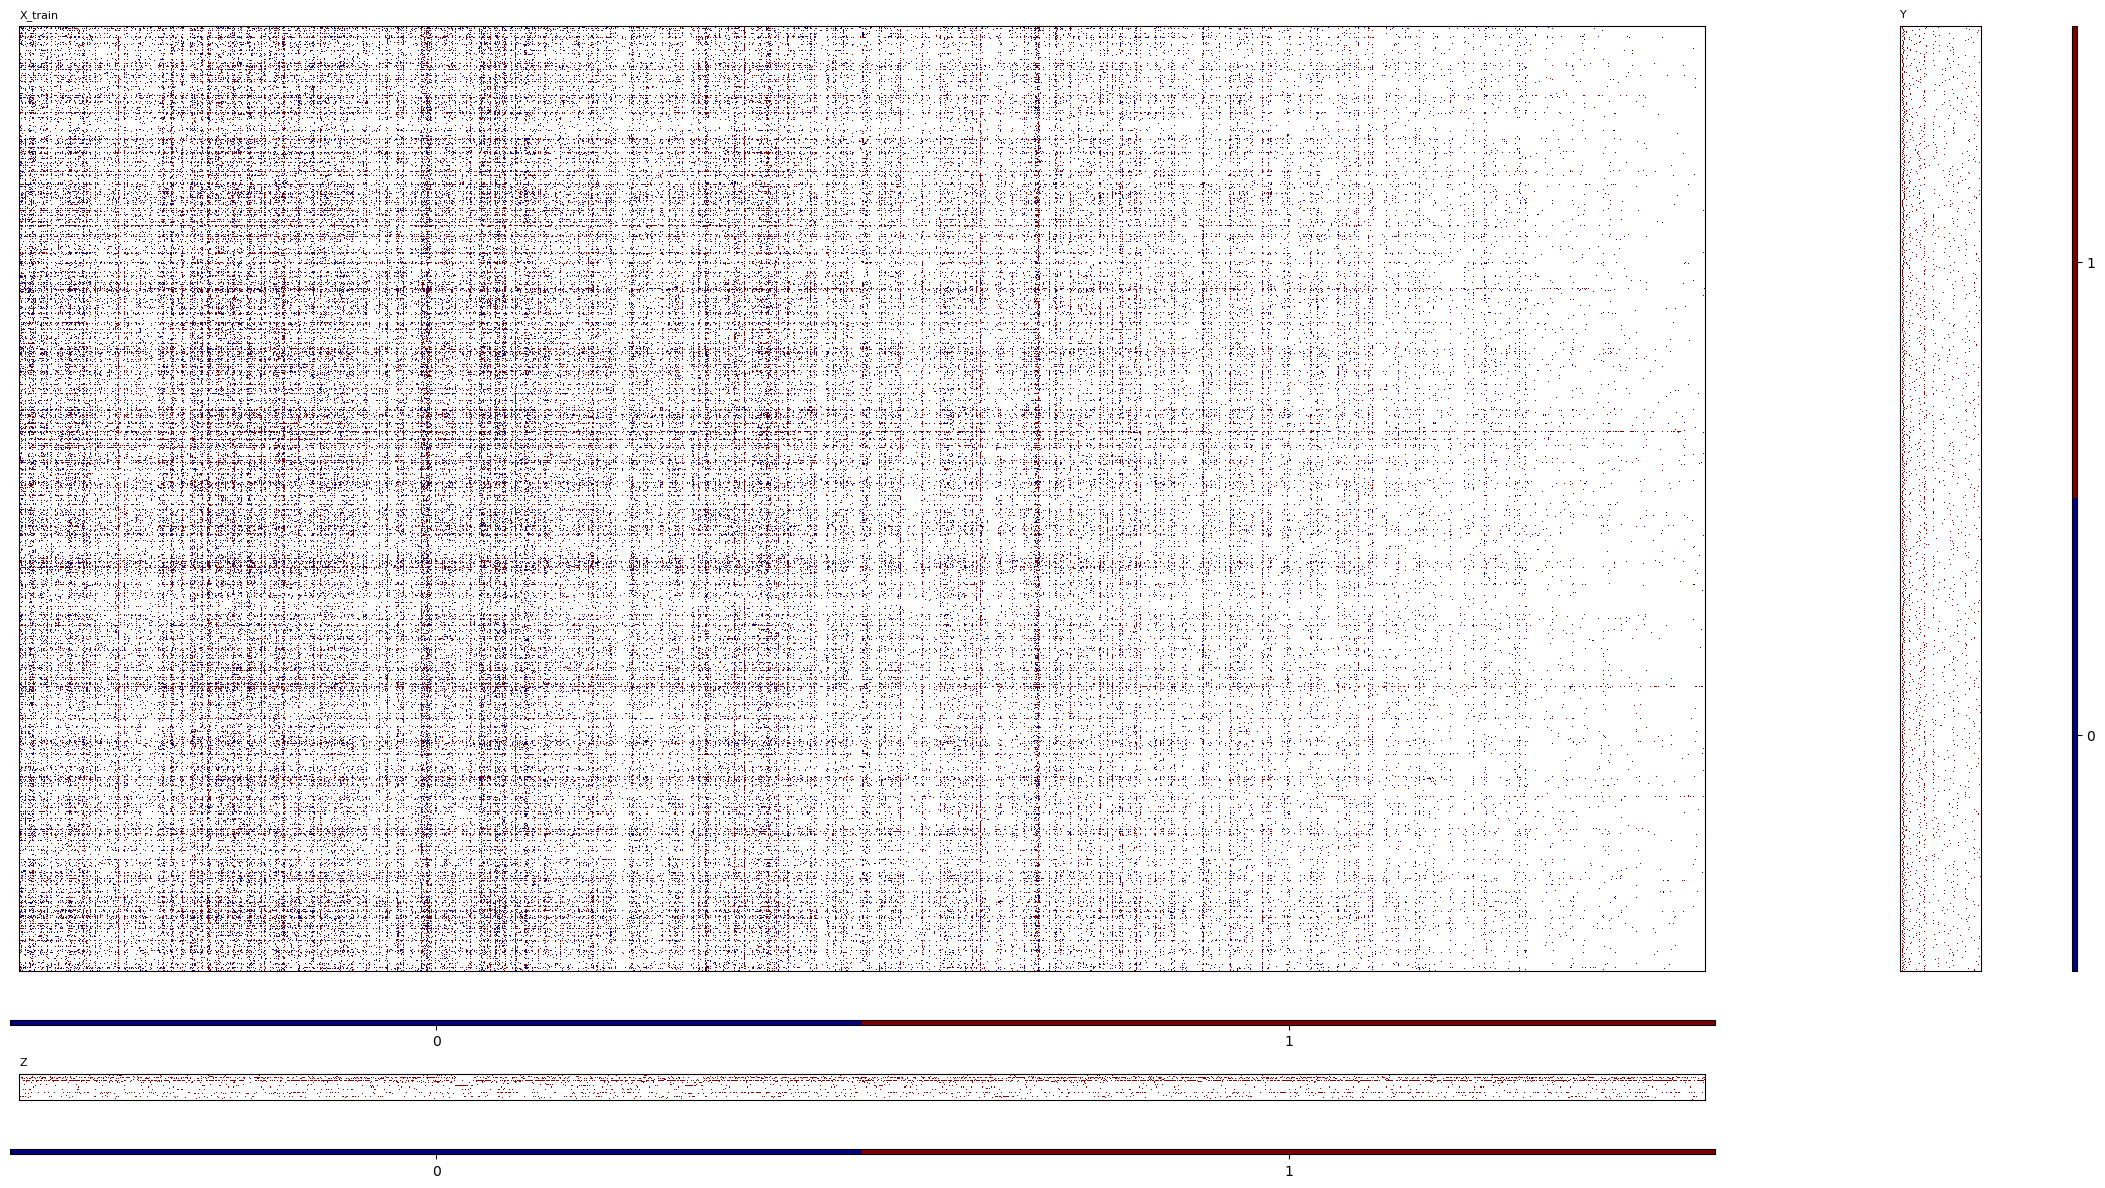

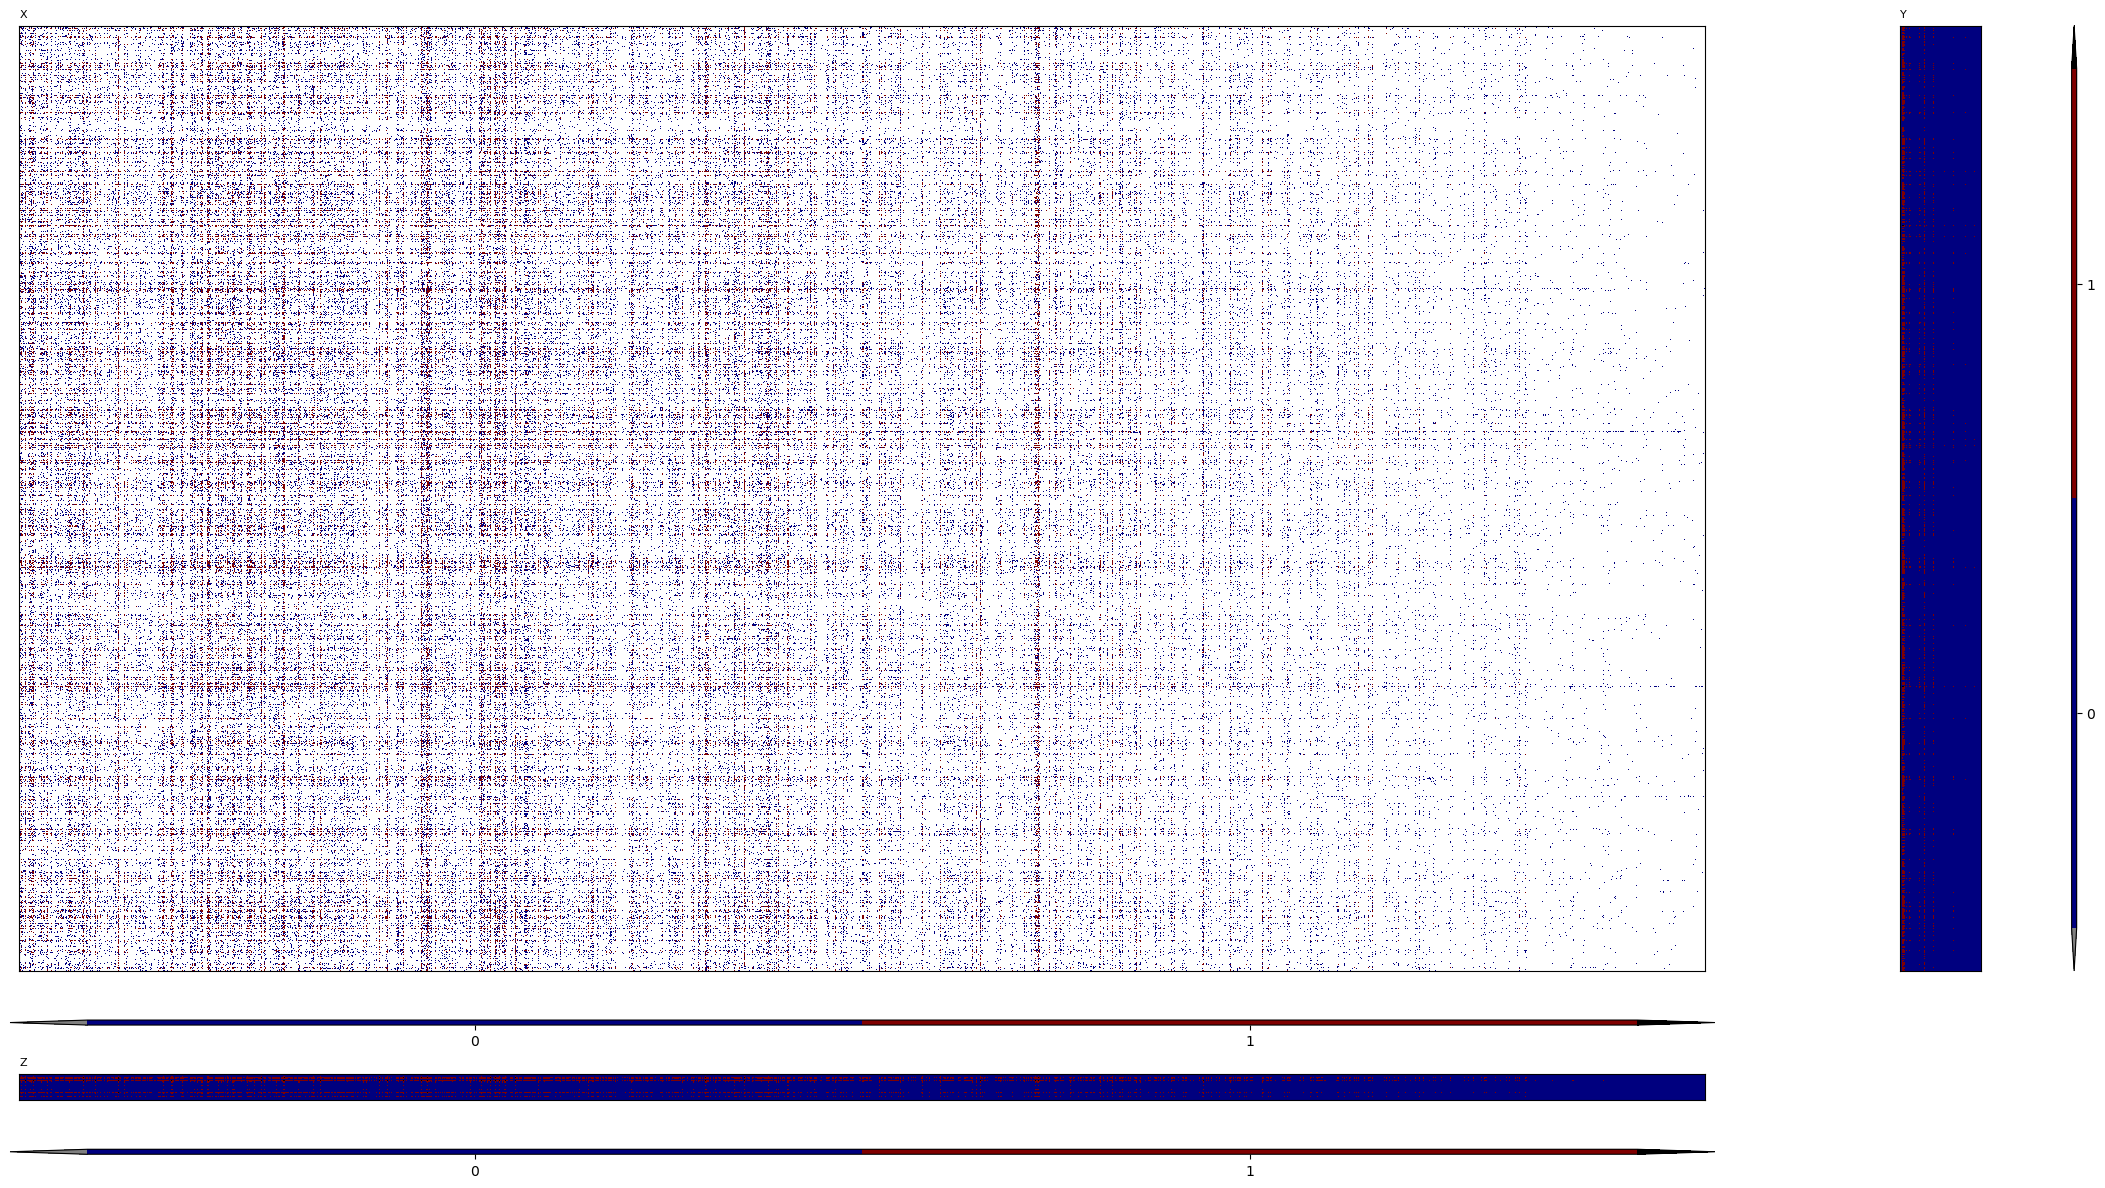

In [23]:
settings = [(X_train, [0, 0], 'X_train'), 
            (Y, [0, 1], 'Y'), 
            (Z, [1, 0], 'Z')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

settings = [(X_recover, [0, 0], 'X'), 
            (Q, [0, 1], 'Y'), 
            (R, [1, 0], 'Z')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

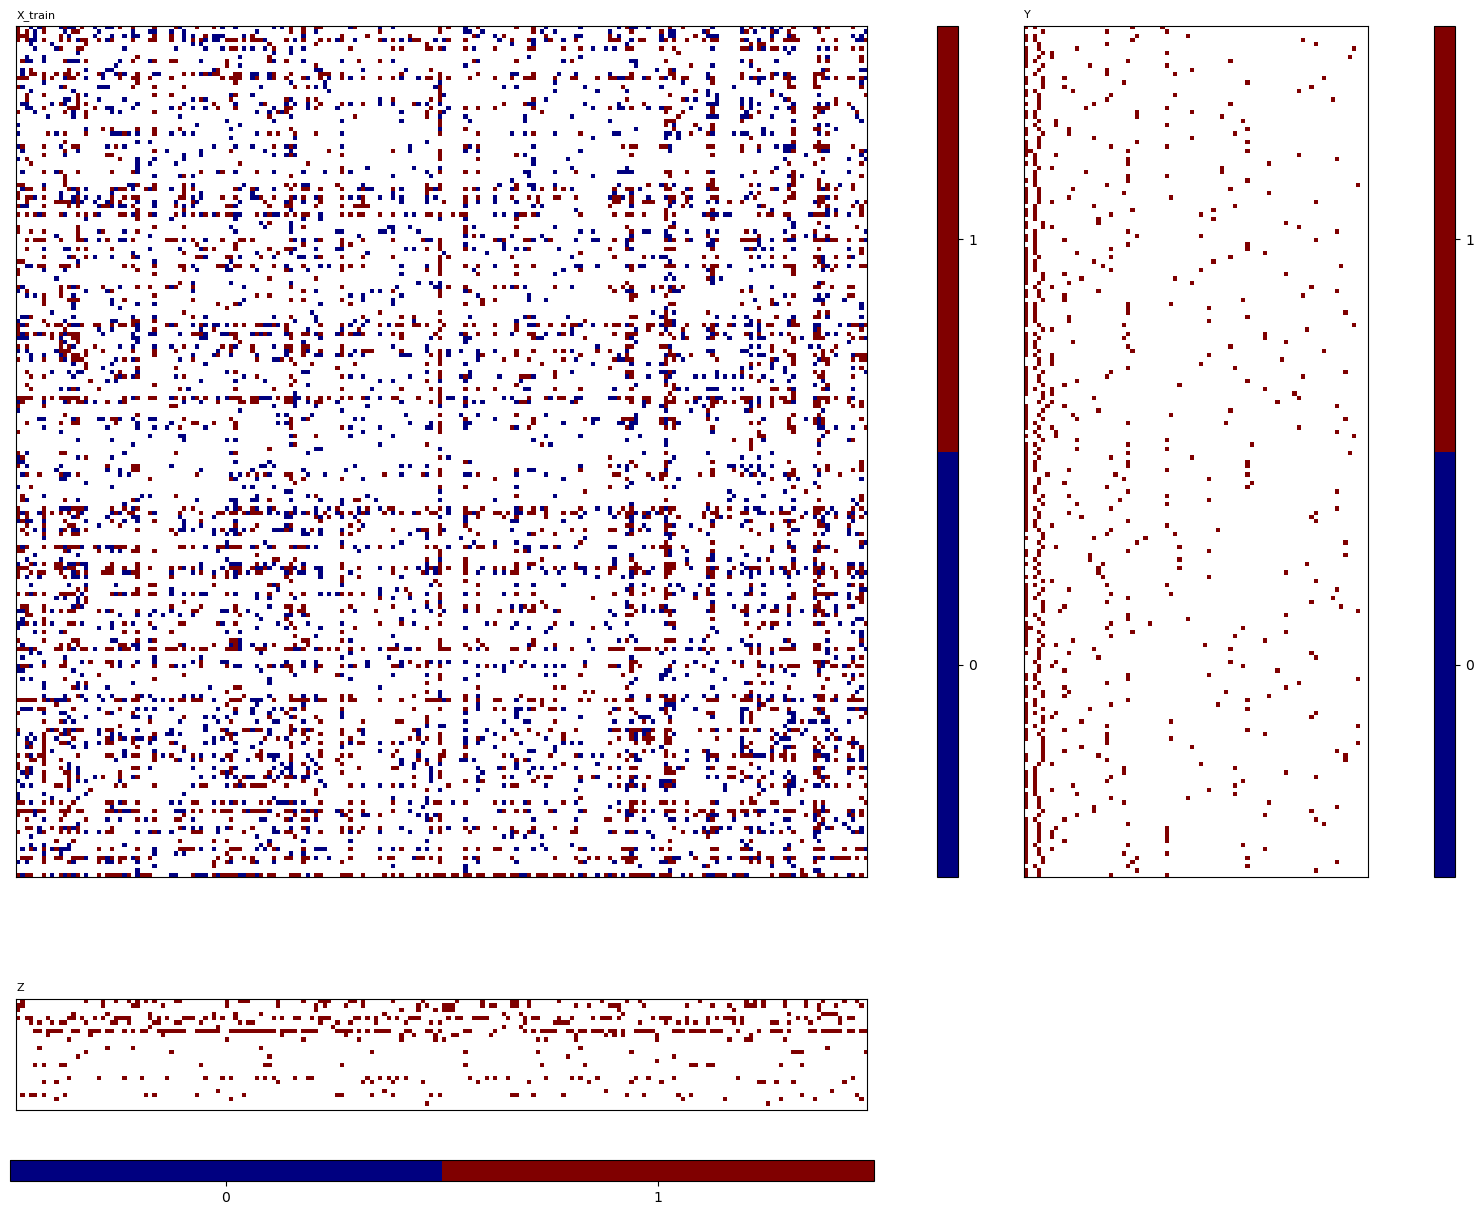

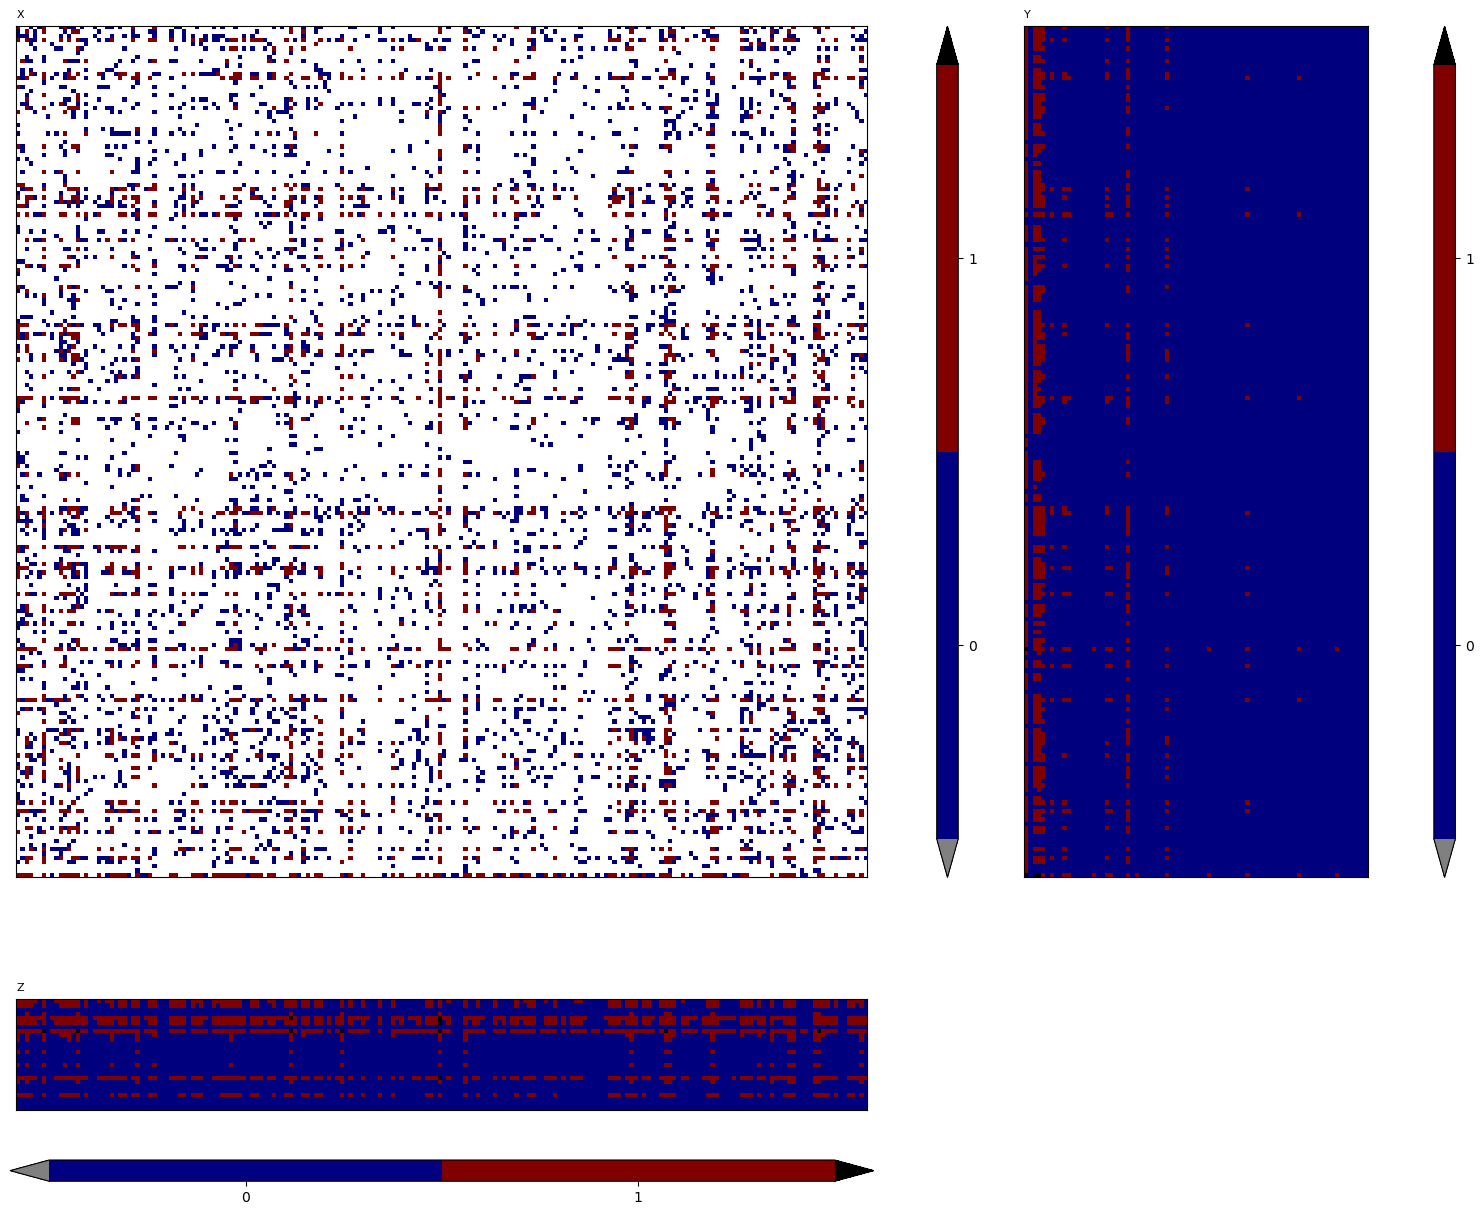

In [24]:
settings = [(X_train[:rng[0], :rng[1]], [0, 0], 'X_train'), 
            (Y[:rng[0], :], [0, 1], 'Y'), 
            (Z[:, :rng[1]], [1, 0], 'Z')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

settings = [(X_recover[:rng[0], :rng[1]], [0, 0], 'X'), 
            (Q[:rng[0], :], [0, 1], 'Y'), 
            (R[:, :rng[1]], [1, 0], 'Z')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=True, center=True, keep_nan=True)

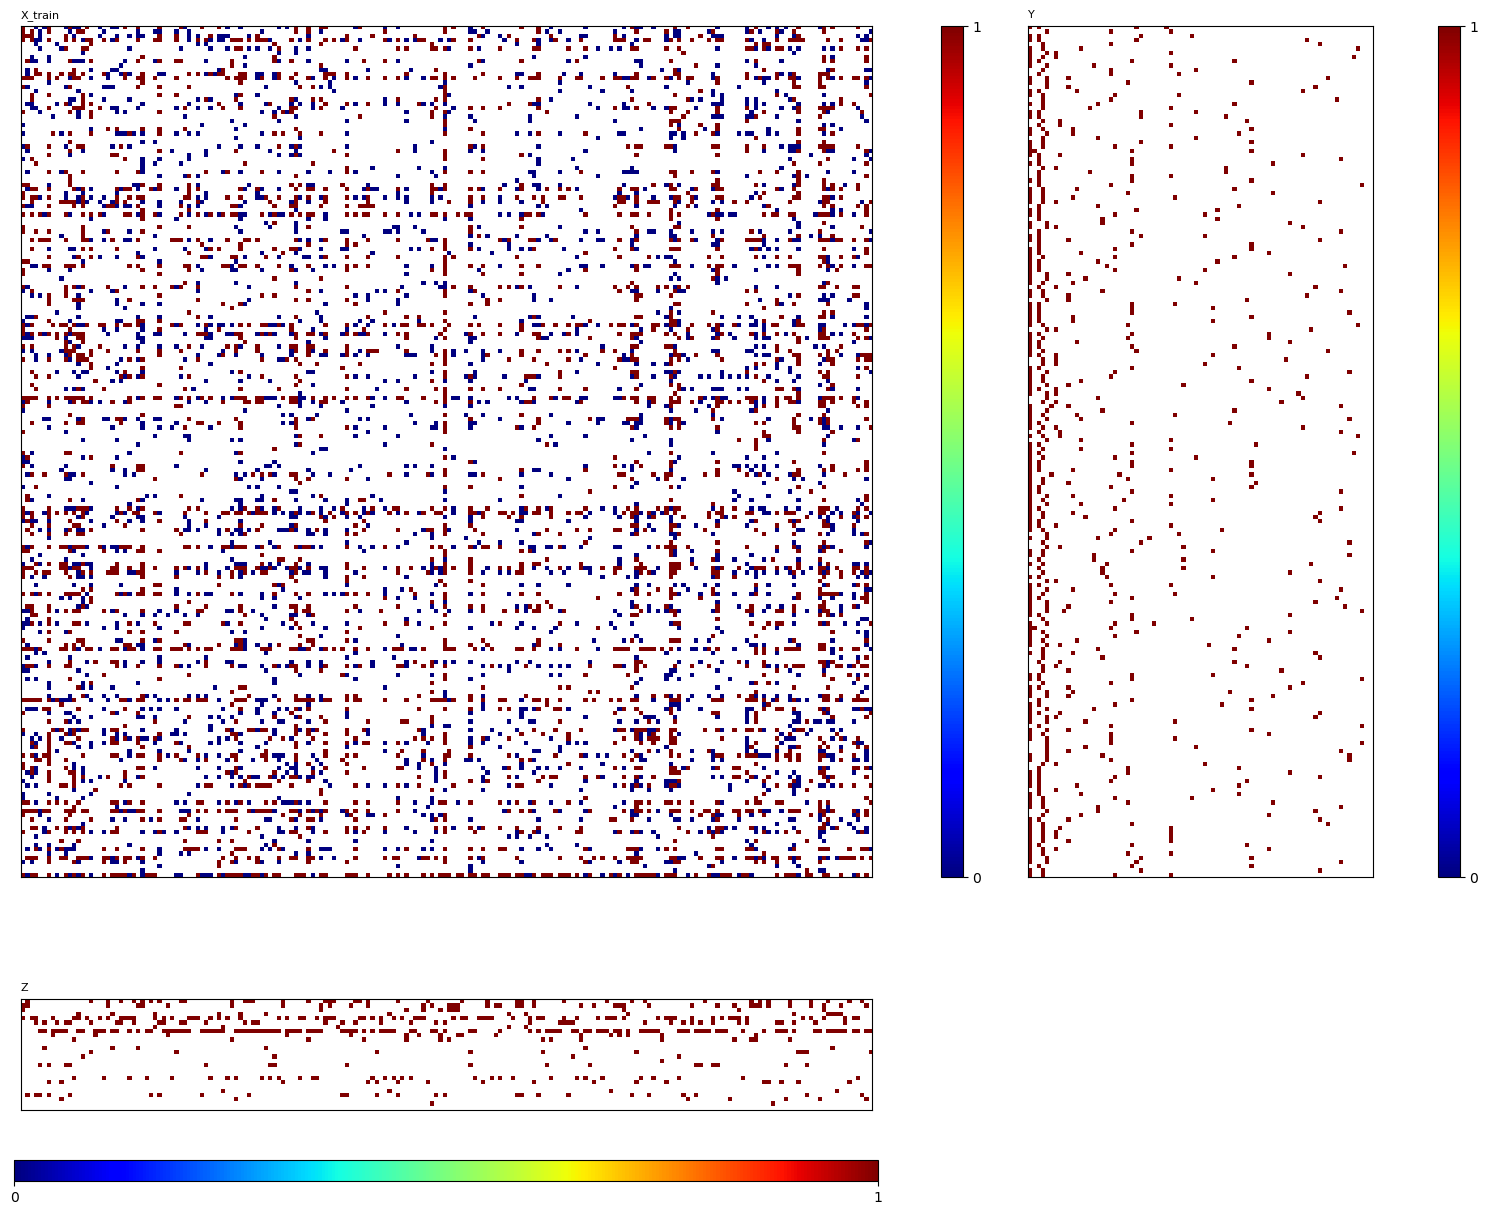

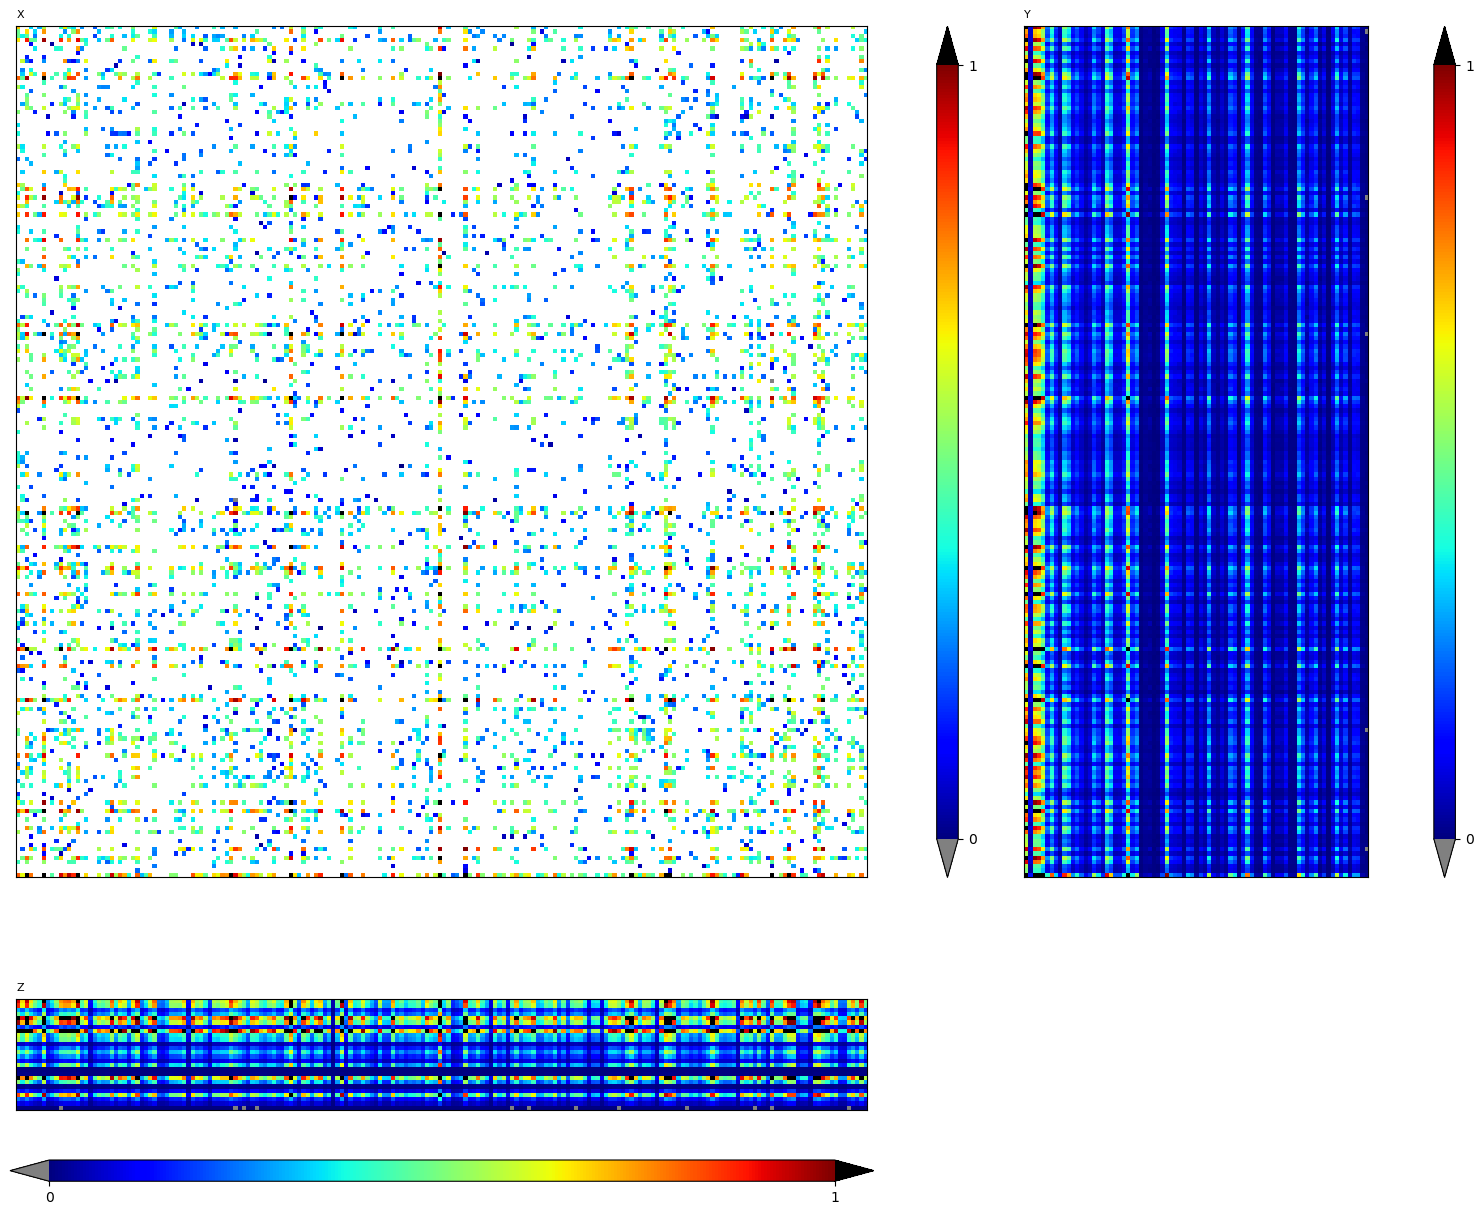

In [25]:
settings = [(X_train[:rng[0], :rng[1]], [0, 0], 'X_train'), 
            (Y[:rng[0], :], [0, 1], 'Y'), 
            (Z[:, :rng[1]], [1, 0], 'Z')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=False, keep_nan=True)

settings = [(X_recover[:rng[0], :rng[1]], [0, 0], 'X'), 
            (Q[:rng[0], :], [0, 1], 'Y'), 
            (R[:, :rng[1]], [1, 0], 'Z')]
show_matrix(settings=settings, colorbar=True, clim=[0, 1], discrete=False, keep_nan=True)

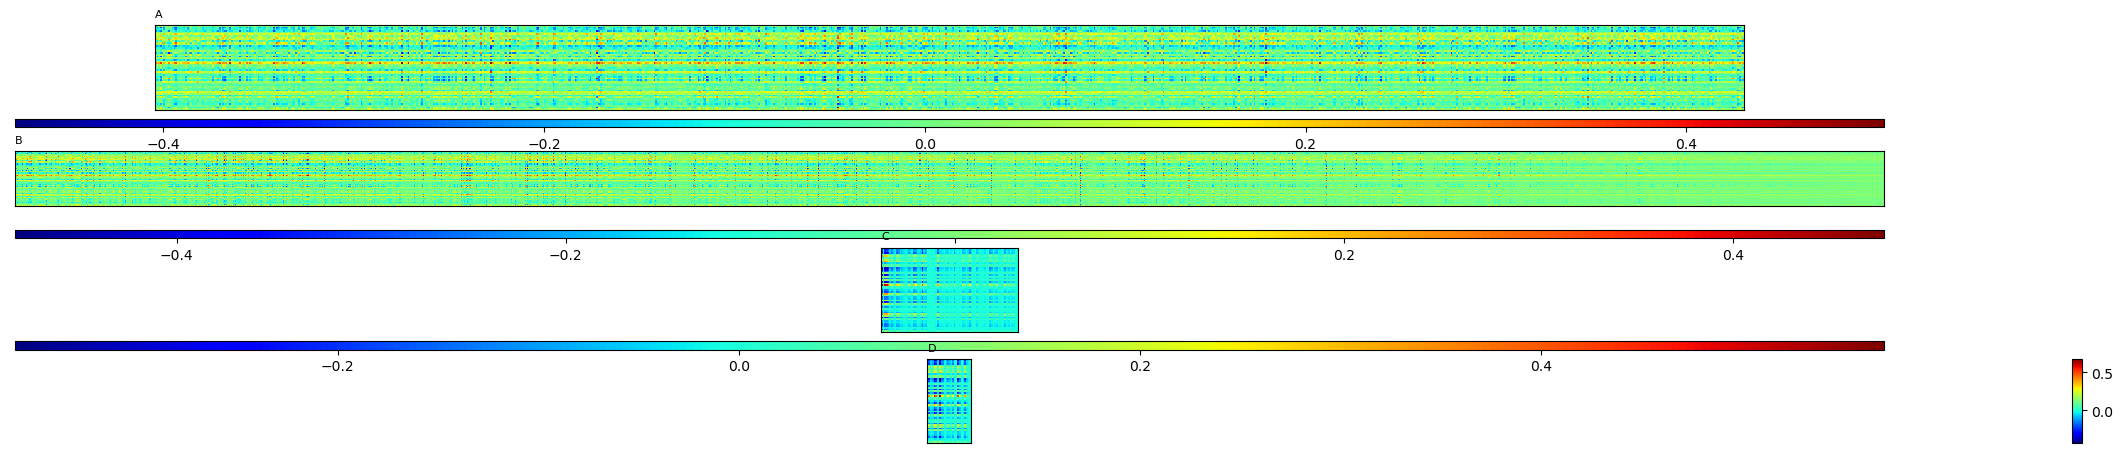

In [27]:
settings = [(A.T, [0, 0], 'A'), 
            (B.T, [1, 0], 'B'), 
            (C.T, [2, 0], 'C'), 
            (D.T, [3, 0], 'D')]
show_matrix(settings=settings, colorbar=True, clim=None, discrete=False, keep_nan=True)

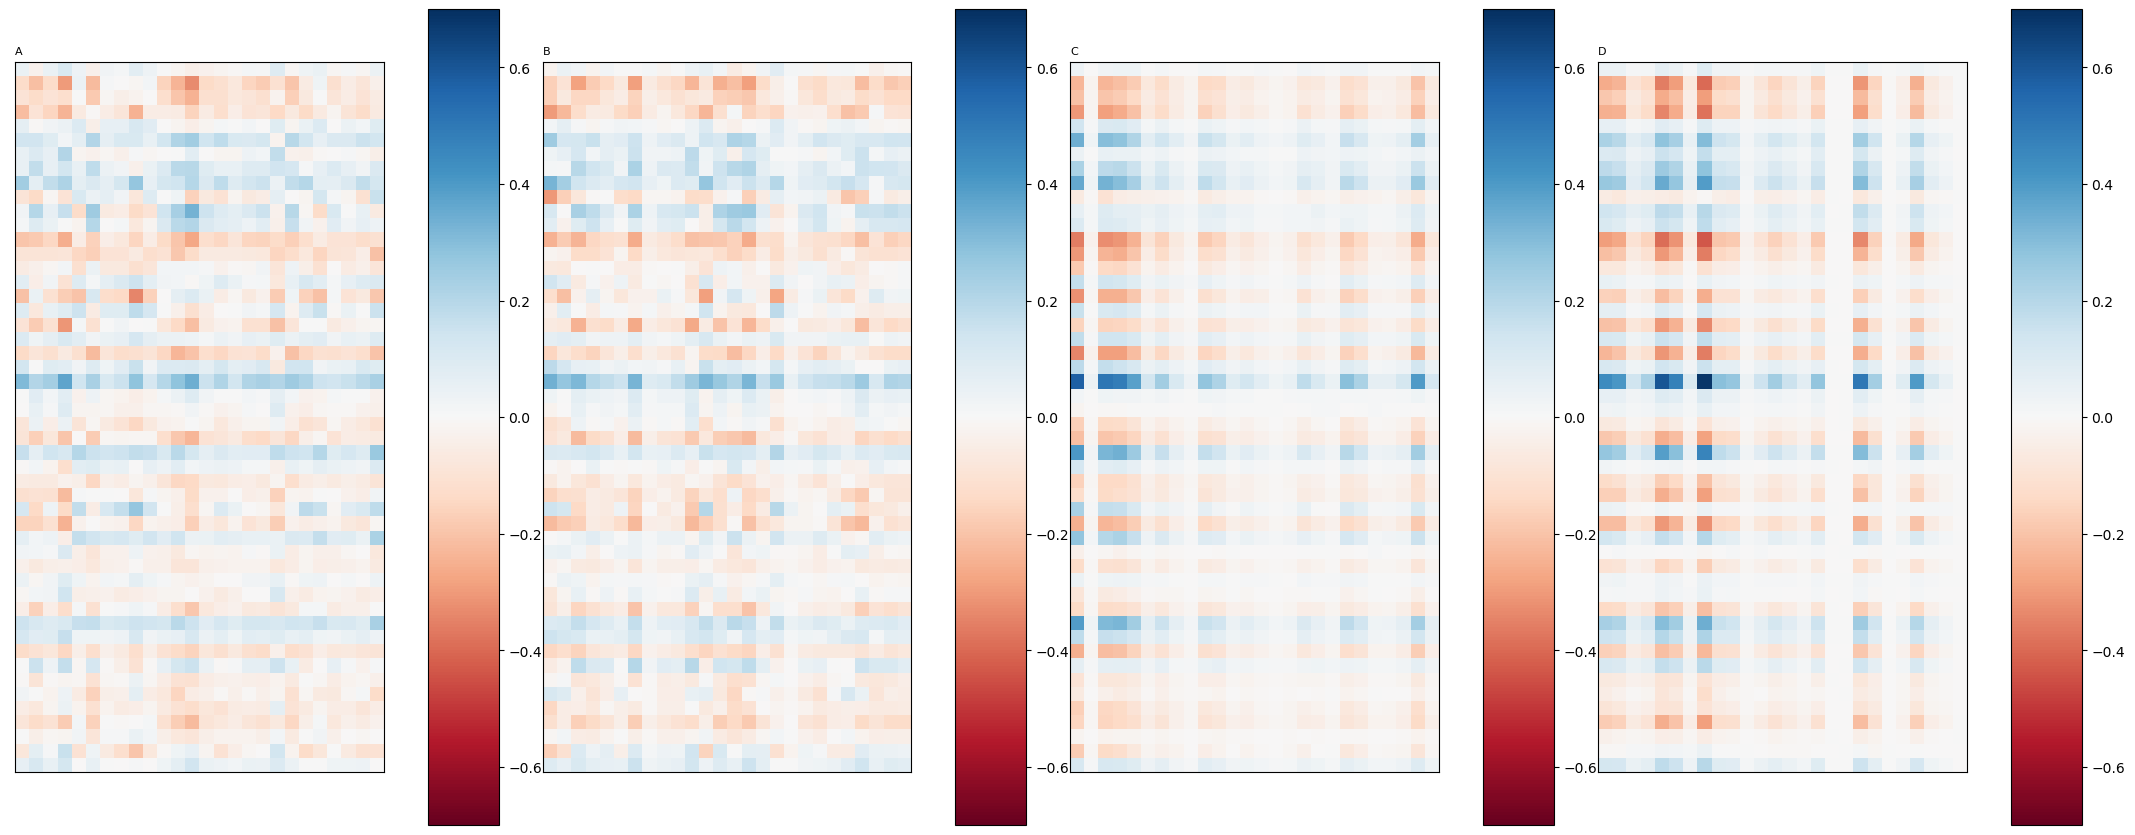

In [33]:
L = D.shape[0]

settings = [(A[:L].T, [0, 0], 'A'), 
            (B[:L].T, [0, 1], 'B'), 
            (C[:L].T, [0, 2], 'C'), 
            (D.T, [0, 3], 'D')]
show_matrix(settings=settings, colorbar=True, clim=[-0.7, 0.7], cmap='RdBu', discrete=False, keep_nan=True)

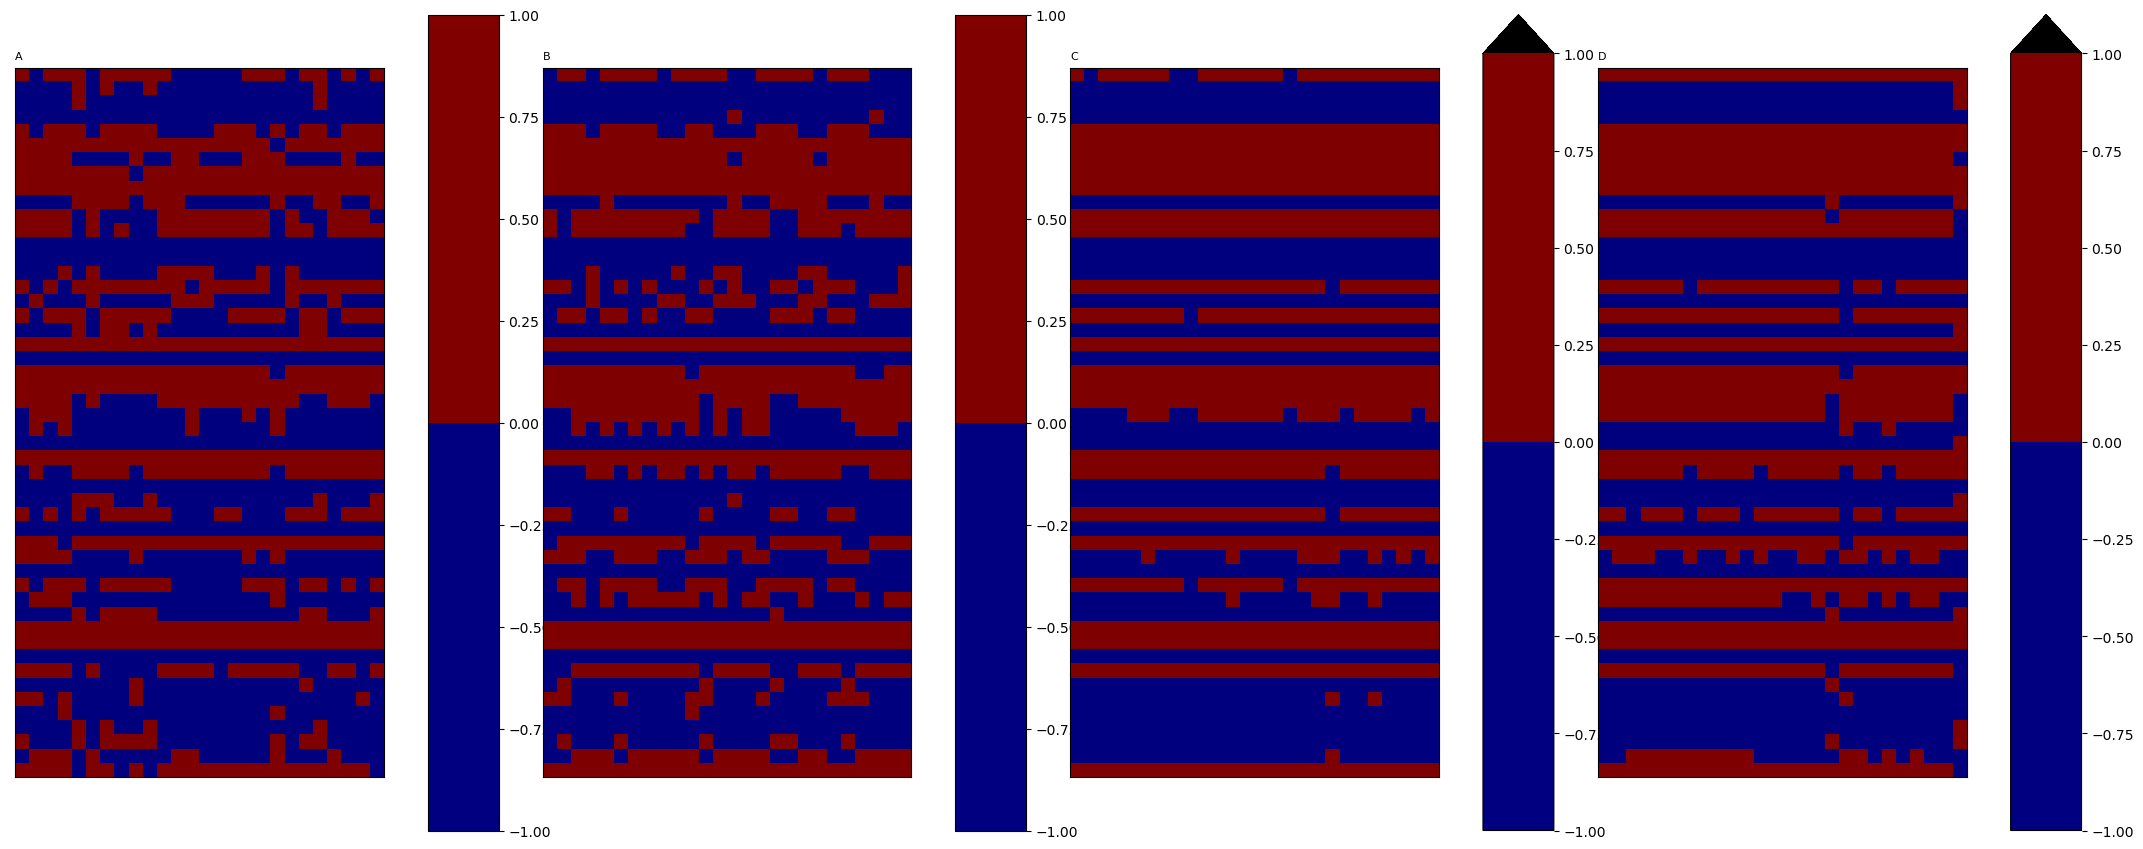

In [32]:
L = D.shape[0]

settings = [(A[:L].T, [0, 0], 'A'), 
            (B[:L].T, [0, 1], 'B'), 
            (C[:L].T, [0, 2], 'C'), 
            (D.T, [0, 3], 'D')]
show_matrix(settings=settings, colorbar=True, clim=[-0.5, 0.5], discrete=True, center=True, keep_nan=True)

In [ ]:
L = D.shape[0]

settings = [(A[:L].T, [0, 0], 'A'), 
            (B[:L].T, [0, 1], 'B'), 
            (C[:L].T, [0, 2], 'C'), 
            (D.T, [0, 3], 'D')]
show_matrix(settings=settings, colorbar=True, clim=[-0.5, 0.5], discrete=True, center=True, keep_nan=True)